In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import os


# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

motion_transform_train = transforms.Compose([normalize])

content_transform_train = transforms.Compose([
                                    transforms.RandomResizedCrop(size=(160,240)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    normalize,
                                ])

class UnlabeledDataset(Dataset):
    def __init__(self, data_dir, num_frames=22, motion_transform=motion_transform_train):
        self.data_dir = data_dir
        self.motion_transform = motion_transform
        self.num_frames = num_frames
        self.video_list = []

        self.count = 0
        for vid_dir in os.listdir(self.data_dir):
            self.video_list.append(self.data_dir +"/"+vid_dir)
            self.count +=1

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        
        video_dir = self.video_list[idx]
        frame_list = []
        
        for i in range(self.num_frames):
            image = read_image(video_dir + "/" + "image_"+str(i)+".png")
            image = image/255.0
            
            if self.motion_transform:
                image = self.motion_transform(image)
            
            frame_list.append(image)  

        return frame_list

class LabeledDataset(Dataset):
    def __init__(self, data_dir, num_frames=22, motion_transform=motion_transform_train):
        self.data_dir = data_dir
        self.motion_transform = motion_transform
        self.num_frames = num_frames
        self.video_list = []

        self.count = 0
        for vid_dir in os.listdir(self.data_dir):
            self.video_list.append(self.data_dir +"/"+vid_dir)
            self.count +=1

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        
        video_dir = self.video_list[idx]
        frame_list = []
        
        for i in range(self.num_frames):
            image = read_image(video_dir + "/" + "image_"+str(i)+".png")
            image = image/255.0
            
            if self.motion_transform:
                image = self.motion_transform(image)
            
            frame_list.append(image)
        
        label = -1
        if os.path.isfile(video_dir+"/mask.npy"):
            try:
                label = np.load(video_dir+"/mask.npy")
            except:
                return None, None
        

        return frame_list, label

In [5]:
unlabeled_data = UnlabeledDataset("/dataset/dataset/unlabeled")
labeled_data = LabeledDataset("/dataset/dataset/train")
val_data = LabeledDataset("/dataset/dataset/val")


train_dataloader = DataLoader(unlabeled_data, batch_size=3, shuffle=True)
downstream_dataloader = DataLoader(labeled_data, batch_size=3, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)

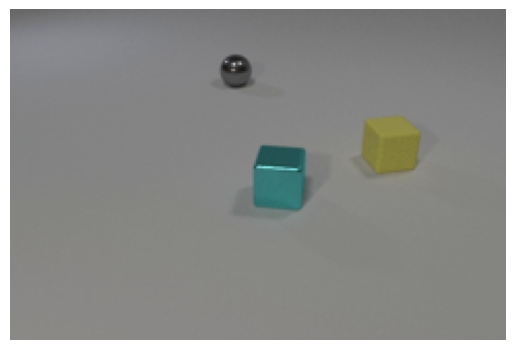

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0).numpy())
    plt.title(title)
    plt.axis('off')

show_normalized_image(unlabeled_data[10][0])

### Updated MC Jepa

In [7]:
def conv(in_features, out_features, kernel_size=3, stride=1, padding=1, dilation=1):   
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=kernel_size, stride=stride, 
                        padding=padding, dilation=dilation),
            nn.BatchNorm2d(out_features),
            nn.LeakyReLU(0.1))

def flow_cnn(in_features):
    return nn.Sequential(
            nn.Conv2d(in_features, 2, kernel_size=3, stride=1, 
                        padding=1),
            nn.BatchNorm2d(2),
            nn.LeakyReLU(0.1))


def deconv(in_planes, out_planes, kernel_size=4, stride=2, padding=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding)


class FEA(nn.Module):
    def __init__ (self, in_features):
        super().__init__()
        self.flow_predictor = flow_cnn(in_features)

    def forward(self, X_tnext, X_hat_tnext):
        correlation = self.corr4D(X_tnext, X_hat_tnext)
        batch_size, out_channels, ht, wd = X_tnext.shape

        mat_mul = torch.matmul(correlation, X_tnext.view(batch_size, out_channels, ht*wd, 1))
        mat_mul = mat_mul.view(batch_size, out_channels, ht, wd)
        x = self.flow_predictor(mat_mul)
        
        return x
    
    @staticmethod
    def corr4D(X_tnext, X_hat_tnext):
        batch, dim, ht, wd = X_tnext.shape
        X_tnext = X_tnext.view(batch, dim, ht*wd)
        X_hat_tnext = X_hat_tnext.view(batch, dim, ht*wd) 

        corr = torch.matmul(X_tnext.transpose(1,2), X_hat_tnext)
        corr = corr.view(batch, 1, ht*wd, ht*wd)
        corr = corr/torch.sqrt(torch.tensor(dim).float())
        return corr
    
#     @staticmethod
#     def upsample(flow, scale = 2, mode='bilinear'):
#         new_size = (scale * flow.shape[2], scale * flow.shape[3])
#         return  scale * F.interpolate(flow, size=new_size, mode=mode, align_corners=True)

def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """

    B, C, H, W = x.size()
    # mesh grid 
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float().to(device)

    if torch.is_tensor(flo): 
        vgrid = torch.autograd.Variable(grid) + flo
    else:
        vgrid = torch.autograd.Variable(grid)

    # scale grid to [-1,1] 
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

    vgrid = vgrid.permute(0,2,3,1)        
    output = nn.functional.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).to(device)
    mask = nn.functional.grid_sample(mask, vgrid)

    mask[mask<0.9999] = 0
    mask[mask>0] = 1
    return output*mask

In [8]:
class MCJepa(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.conv1 = conv(in_features, 4, 3, 2)
        self.conv1a = conv(4, 4, 3)
        self.conv2 = conv(4, 8, 3, 2)
        self.conv2a = conv(8, 8, 3)
#         self.conv3 = conv(8, 16, 3, 2)
#         self.conv3a = conv(16, 16, 3)
#         self.conv4 = conv(64, 128, 3, 2)
#         self.conv4a = conv(128, 128, 3)
        
#         self.fea4 = FEA(128)
#         self.deconv4 = deconv(2, 2)
        
#         self.fea3 = FEA(16)
#         self.deconv3 = deconv(2, 2)
        
        self.fea2 = FEA(8)
        self.deconv2 = deconv(2, 2)
        
        self.fea1 = FEA(4)
        self.deconv1 = deconv(2, 2)
        
        
    def forward(self, I_t, I_tnext): # , I_tcrop):
        
        X_t = None
        X_tnext = None
        X_hat_tnext = None
        X_hat_t = None
        f_t_tnext = None
        f_tnext_t = []
        
        # Image t downsampling
        I_t_x1 = self.conv1a(self.conv1(I_t))
        I_t_x2 = self.conv2a(self.conv2(I_t_x1))
#         I_t_x3 = self.conv3a(self.conv3(I_t_x2))
#         I_t_x4 = self.conv4a(self.conv4(I_t_x3))
        
#         X_t = [I_t_x1, I_t_x2, I_t_x3, I_t_x4]
#         X_t = [I_t_x1, I_t_x2, I_t_x3]
        X_t = [I_t_x1, I_t_x2]
        
        # Image t+1 downsampling
        I_tnext_x1 = self.conv1a(self.conv1(I_tnext))
        I_tnext_x2 = self.conv2a(self.conv2(I_tnext_x1))
#         I_tnext_x3 = self.conv3a(self.conv3(I_tnext_x2))
#         I_tnext_x4 = self.conv4a(self.conv4(I_tnext_x3))
        
#         X_tnext = [I_tnext_x1, I_tnext_x2, I_tnext_x3, I_tnext_x4]
#         X_tnext = [I_tnext_x1, I_tnext_x2, I_tnext_x3]
        X_tnext = [I_tnext_x1, I_tnext_x2]

        ### Image t -> t+1
#         flow4 = self.fea4(I_t_x4, I_tnext_x4)
#         upflow4 = self.deconv4(flow4)
#         I_tnext_x3_hat = warp(I_t_x3, upflow4*0.625)
        
#         flow3 = self.fea3(I_tnext_x3_hat, I_tnext_x3)
#         flow3 = flow3 + upflow4

#         flow3 = self.fea3(I_t_x3, I_tnext_x3)
#         upflow3 = self.deconv3(flow3)
#         I_tnext_x2_hat = warp(I_t_x2, upflow3*2.5)
        
        flow2 = self.fea2(I_t_x2, I_tnext_x2)
#         flow2 = flow2 + upflow3
        upflow2 = self.deconv2(flow2)
        I_tnext_x1_hat = warp(I_t_x1, upflow2*0.625)
        
        flow1 = self.fea1(I_tnext_x1_hat, I_tnext_x1)
        flow1 = flow1 + upflow2
        upflow1 = self.deconv1(flow1)
        I_tnext_hat = warp(I_t, upflow1*1.25)
        
#         X_hat_tnext = [I_tnext_x1_hat, I_tnext_x2_hat, I_tnext_x3_hat]
#         X_hat_tnext = [I_tnext_x1_hat, I_tnext_x2_hat]
        X_hat_tnext = [I_tnext_x1_hat]
#         f_t_tnext = [upflow4, upflow3, upflow2, upflow1]
#         f_t_tnext = [flow1, flow2, flow3]
        f_t_tnext = [flow1, flow2]
        
        ### Image t+1 -> t
#         rev_flow4 = self.fea4(I_tnext_x4, I_t_x4)
#         rev_upflow4 = self.deconv4(rev_flow4)
#         I_t_x3_hat = warp(I_tnext_x3, rev_upflow4*0.625)
        
#         rev_flow3 = self.fea3(I_t_x3_hat, I_t_x3)
#         rev_flow3 = rev_flow3 + rev_upflow4

#         rev_flow3 = self.fea3(I_tnext_x3, I_t_x3)
#         rev_upflow3 = self.deconv3(rev_flow3)
#         I_t_x2_hat = warp(I_tnext_x2, rev_upflow3*2.5)


        rev_flow2 = self.fea2(I_tnext_x2, I_t_x2)
#         rev_flow2 = rev_flow2 + rev_upflow3
        rev_upflow2 = self.deconv2(rev_flow2)
        I_t_x1_hat = warp(I_tnext_x1, rev_upflow2*0.625)
        
        rev_flow1 = self.fea1(I_t_x1_hat, I_t_x1)
        rev_flow1 = rev_flow1 + rev_upflow2
        rev_upflow1 = self.deconv1(rev_flow1)
        I_t_hat = warp(I_tnext, rev_upflow1*1.25)
        
#         X_hat_t = [I_t_x1_hat, I_t_x2_hat, I_t_x3_hat]
#         f_t_tnext = [rev_upflow4, rev_upflow3, rev_upflow2, rev_upflow1]
        
#         X_hat_t = [I_t_x1_hat, I_t_x2_hat]
#         f_tnext_t = [rev_flow1, rev_flow2, rev_flow3]

        X_hat_t = [I_t_x1_hat]
        f_tnext_t = [rev_flow1, rev_flow2]
        
        return X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_t_hat, I_tnext_hat
    

In [9]:
# a = torch.zeros([1, 3, 160, 240]).to(device)
# b = torch.zeros([1, 3, 160, 240]).to(device)

# mcmodel = MCJepa(3).to(device)
# mcmodel(a, b)


In [10]:
def off_diagonal(M):
    res = M.clone()
    res.diagonal(dim1=-1, dim2=-2).zero_()
    return res

def vc_reg(X_t, X_tnext, lm, mu, nu):
    N = X_t.shape[0]
    C = X_t.shape[1]
    H = X_t.shape[2]
    W = X_t.shape[3] 
    D = C + H + W 
    mse_loss = nn.MSELoss()
    sim_loss = mse_loss(X_t, X_tnext)
    
    std_z_a = torch.sqrt(X_t.var(dim=0) + 1e-04)
    std_z_b = torch.sqrt(X_tnext.var(dim=0) + 1e-04)
    std_loss = torch.mean(F.relu(1-std_z_a)) + torch.mean(F.relu(1-std_z_b))

    X_t = X_t - X_t.mean(dim=0)
    X_tnext = X_tnext - X_tnext.mean(dim=0)
    cov_z_a = torch.matmul(X_t.view(N, C, W, H), X_t)/ (N-1)
    cov_z_b = torch.matmul(X_tnext.view(N, C, W, H), X_tnext)/ (N-1)
    conv_loss = (off_diagonal(cov_z_a).pow_(2).sum()/D) + (off_diagonal(cov_z_b).pow_(2).sum()/D) 
        
    loss = lm*sim_loss + mu*std_loss + nu*conv_loss
    return loss

def cycle_loss_fn(f_t_tnext, f_tnext_t, X_t, X_tnext, lambda_a, lambda_b):
    loss_cycle_A = torch.tensor(0.0).to(device)
    loss_cycle_B = torch.tensor(0.0).to(device)
    for i in range(1, len(X_t)):
        loss_cycle_A += F.l1_loss(warp(X_t[i], f_t_tnext[i]), X_tnext[i]) * lambda_a
        loss_cycle_B += F.l1_loss(warp(X_tnext[i], f_tnext_t[i]), X_t[i]) * lambda_b
        
    return loss_cycle_A + loss_cycle_B

In [14]:
def MCJepa_criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext, img1, img2, lm, mu, nu, lambda_a, lambda_b,show=False):
  
    mse_loss = nn.MSELoss()    
    rec_loss = nn.MSELoss()
    reg_loss = nn.MSELoss()
    
    regress_loss_forward = torch.tensor(0.0).to(device)
    regress_loss_backward = torch.tensor(0.0).to(device)
    for i in range(len(X_hat_tnext)):
        regress_loss_forward += reg_loss(X_hat_tnext[i], X_tnext[i])
        regress_loss_backward += reg_loss(X_hat_t[i], X_t[i])

    reconst_loss_forward = rec_loss(I_hat_tnext, img2)
    reconst_loss_backward = rec_loss(I_hat_t, img1)
    vc_reg_loss = torch.tensor(0.0).to(device)
    
    for i in range(len(X_t)):
        vc_reg_loss += vc_reg(X_t[i], X_tnext[i], lm, mu, nu)

    cycle_loss = cycle_loss_fn(f_t_tnext, f_tnext_t, X_t, X_tnext, lambda_a, lambda_b)
    
    if show:
        print("regress_loss_forward: ",50*regress_loss_forward)
        print("regress_loss_backward: ",50*regress_loss_backward)
        print("reconst_loss_forward: ",1000*reconst_loss_forward)
        print("reconst_loss_backward: ",1000*reconst_loss_backward)
        print("vc_reg_loss: ",vc_reg_loss)
        print("cycle_loss: ",50*cycle_loss)

        print("\n\n")

    
    return 50*regress_loss_forward + 50*regress_loss_backward + 1000*reconst_loss_forward + 1000*reconst_loss_backward + 50*cycle_loss + vc_reg_loss 



In [15]:
from tqdm import tqdm

def train_MCJepa(model, epochs, dataloader, criterion, optimizer):
    model.train()

    train_losses = []

    best_loss = float("inf")
    best_model = model.state_dict()

    for _ in range(epochs):
        total_train_loss = 0.0
        total_train_correct = 0.0
        
        pbar = tqdm(dataloader, leave=False)

        for j,batch in enumerate(pbar):
            if j == 4333: 
                break

            frame_list = batch
            total_train_loss = 0.0
            
            for i in range(len(frame_list) - 1):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
#                 print(img1.shape)
                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext = model(img1, img2)

                loss = criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                                f_tnext_t, I_hat_t, I_hat_tnext, img1, img2,\
                                lm, mu, nu, lambda_a, lambda_b,(i+21*j)%660 == 0)
            
                total_train_loss += loss.item()
            
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            pbar.set_postfix({'Video Loss': total_train_loss/(len(frame_list)-1)})

            if total_train_loss/(len(frame_list)-1) < best_loss:
                best_loss = total_train_loss/(len(frame_list)-1)
                best_model = model.state_dict()
                
            if j % 30 == 0 and j > 0:
                torch.save(best_model,"best_model.pth")
                pbar.set_postfix({'Video Loss': total_train_loss/(len(frame_list)-1), 'Saved model with loss': best_loss})
            
        pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved model at j': j})
        torch.save(model.state_dict(), "best_model.pth")

In [16]:
# Constants to figure out later
in_features = 3 
lm, mu, nu, lambda_a, lambda_b = 0.02, 0.02, 0.01, 1, 1

In [17]:
MCJepa_model = MCJepa(in_features).to(device)
optimizer = optim.SGD(MCJepa_model.parameters(), lr = 0.001)

In [ ]:
train_MCJepa(MCJepa_model, 1, train_dataloader, MCJepa_criterion, optimizer) # Training the MC JEPA

  0%|          | 0/4334 [00:00<?, ?it/s]/home/sd5313/.local/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


regress_loss_forward:  tensor(18.7035, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(18.5515, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(7.8775, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(7.5275, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(338.8364, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(13.6752, device='cuda:0', grad_fn=<MulBackward0>)





  1%|          | 31/4334 [01:22<3:07:34,  2.62s/it, Per frame Loss=64.3, Saved model with loss=37.6]

regress_loss_forward:  tensor(0.0175, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0197, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(18.0519, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(19.0235, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.5631, device='cuda:0', grad_fn=<MulBackward0>)





  1%|▏         | 62/4334 [02:43<3:07:05,  2.63s/it, Per frame Loss=46.4]                            

regress_loss_forward:  tensor(0.0199, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0192, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(17.0525, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(16.9897, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.4673, device='cuda:0', grad_fn=<MulBackward0>)





  2%|▏         | 94/4334 [04:06<3:05:00,  2.62s/it, Per frame Loss=51.1]                            

regress_loss_forward:  tensor(0.0445, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0486, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(53.4465, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(55.6321, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.6528, device='cuda:0', grad_fn=<MulBackward0>)





  3%|▎         | 125/4334 [05:28<3:03:27,  2.62s/it, Per frame Loss=234]                             

regress_loss_forward:  tensor(0.0446, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0409, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(41.1796, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(40.5486, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.4397, device='cuda:0', grad_fn=<MulBackward0>)





  4%|▎         | 157/4334 [06:51<3:02:06,  2.62s/it, Per frame Loss=53.4]                            

regress_loss_forward:  tensor(0.0295, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0314, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(31.7117, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(32.5709, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.2853, device='cuda:0', grad_fn=<MulBackward0>)





  4%|▍         | 188/4334 [08:12<3:00:33,  2.61s/it, Per frame Loss=58.1]                            

regress_loss_forward:  tensor(0.0140, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0138, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(13.9846, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(14.2538, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.1499, device='cuda:0', grad_fn=<MulBackward0>)





  5%|▌         | 220/4334 [09:36<2:58:36,  2.60s/it, Per frame Loss=48.1]                            

regress_loss_forward:  tensor(0.0043, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0043, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(2.6101, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(2.6021, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0941, device='cuda:0', grad_fn=<MulBackward0>)





  6%|▌         | 251/4334 [10:57<2:56:09,  2.59s/it, Per frame Loss=49.1]                            

regress_loss_forward:  tensor(0.0168, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0166, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(38.3673, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(37.4074, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.1026, device='cuda:0', grad_fn=<MulBackward0>)





  7%|▋         | 282/4334 [12:26<3:17:00,  2.92s/it, Per frame Loss=58.5]                            

regress_loss_forward:  tensor(0.0075, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0076, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(24.6461, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(24.6922, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0493, device='cuda:0', grad_fn=<MulBackward0>)





  7%|▋         | 314/4334 [13:54<2:54:27,  2.60s/it, Per frame Loss=48.8]                            

regress_loss_forward:  tensor(0.0063, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0071, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(31.6045, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(31.4855, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0606, device='cuda:0', grad_fn=<MulBackward0>)





  8%|▊         | 345/4334 [15:14<2:52:03,  2.59s/it, Per frame Loss=35.4]                            

regress_loss_forward:  tensor(0.0130, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(32.4130, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(33.2443, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0164, device='cuda:0', grad_fn=<MulBackward0>)





  9%|▊         | 377/4334 [16:37<2:50:47,  2.59s/it, Per frame Loss=44.2]                            

regress_loss_forward:  tensor(0.0073, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0077, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(31.3385, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(32.1907, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0069, device='cuda:0', grad_fn=<MulBackward0>)





  9%|▉         | 408/4334 [18:02<3:11:47,  2.93s/it, Per frame Loss=72.6]                            

regress_loss_forward:  tensor(0.0070, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0070, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(24.5659, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(24.4282, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)





 10%|█         | 440/4334 [19:25<2:47:48,  2.59s/it, Per frame Loss=35.6]                            

regress_loss_forward:  tensor(0.0333, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0332, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(59.3592, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(58.9455, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0014, device='cuda:0', grad_fn=<MulBackward0>)





 11%|█         | 471/4334 [20:45<2:46:27,  2.59s/it, Per frame Loss=45.4]                            

regress_loss_forward:  tensor(0.0145, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0142, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(21.7337, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(20.7934, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0009, device='cuda:0', grad_fn=<MulBackward0>)





 12%|█▏        | 502/4334 [22:05<2:43:33,  2.56s/it, Per frame Loss=40.4]                            

regress_loss_forward:  tensor(0.0251, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0252, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(21.5055, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(24.0490, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)





 12%|█▏        | 534/4334 [23:29<2:44:37,  2.60s/it, Per frame Loss=46.2]                          

regress_loss_forward:  tensor(0.0386, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0394, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(30.4263, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(30.7378, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0009, device='cuda:0', grad_fn=<MulBackward0>)





 13%|█▎        | 565/4334 [24:49<2:44:07,  2.61s/it, Per frame Loss=29.5]                            

regress_loss_forward:  tensor(0.0349, device='cuda:0', grad_fn=<MulBackward0>)
regress_loss_backward:  tensor(0.0340, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_forward:  tensor(32.4779, device='cuda:0', grad_fn=<MulBackward0>)
reconst_loss_backward:  tensor(31.7513, device='cuda:0', grad_fn=<MulBackward0>)
vc_reg_loss:  tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)
cycle_loss:  tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)





 14%|█▎        | 588/4334 [25:49<2:41:50,  2.59s/it, Per frame Loss=55.8]                            

In [13]:
PATH = "best_model.pth"
MCJepa_model = MCJepa(in_features).to(device)
MCJepa_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
flow_1 = 0
flow_2 = 0

Loss:  26.06662368774414
tensor(False, device='cuda:0')


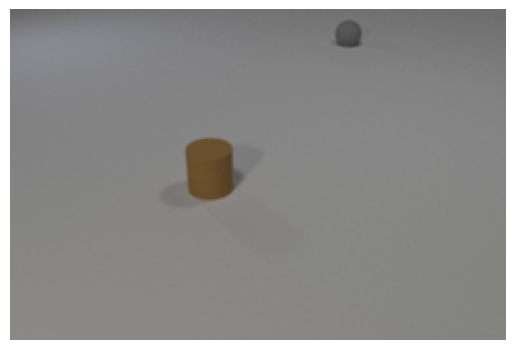

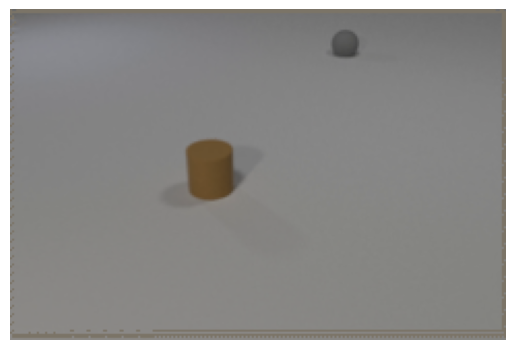

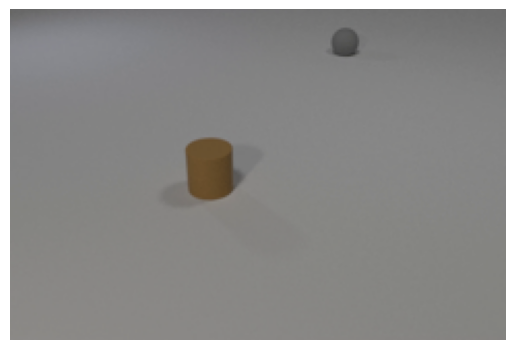

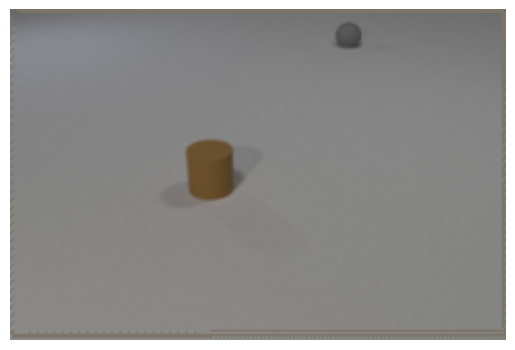

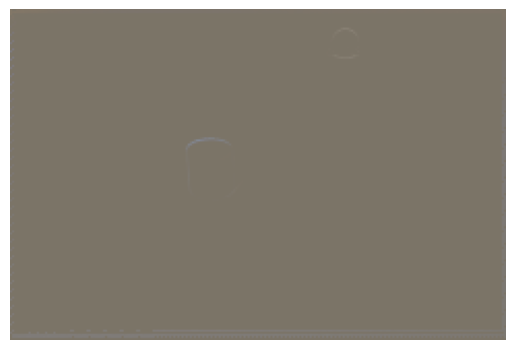

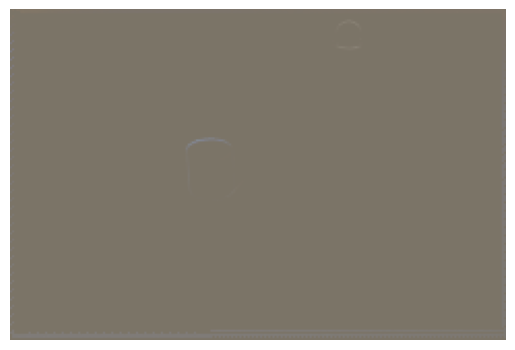

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.12 GiB (GPU 0; 15.78 GiB total capacity; 11.09 GiB already allocated; 540.19 MiB free; 14.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

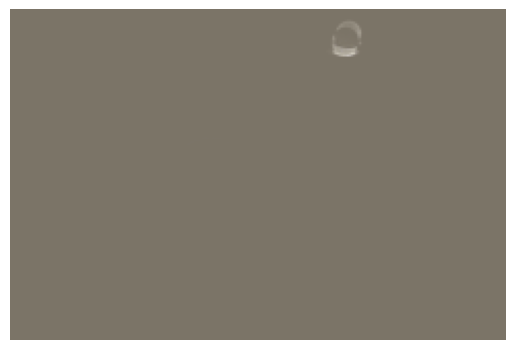

In [17]:
for batch in train_dataloader:
#     MCJepa_model.reset_flows()
    frame_list = batch
    img1 = frame_list[0].to(device)
    img2 = frame_list[1].to(device)

    X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext = MCJepa_model(img1, img2)

    loss = MCJepa_criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                    f_tnext_t, I_hat_t, I_hat_tnext, img1, img2,\
                     lm, mu, nu, lambda_a, lambda_b)
    
    print("Loss: ", loss.item())
#     flow_1 = f_t_tnext
    flow_2 = f_t_tnext
#     print(f_t_tnext[0])
    print((f_t_tnext[0] == 0).all())
    

    show_normalized_image(img1[0])
    plt.show()
    show_normalized_image(I_hat_t[0])
    plt.show()
    show_normalized_image(img2[0])
    plt.show()
    show_normalized_image(I_hat_tnext[0])
    plt.show()
    show_normalized_image(torch.square(I_hat_t[0]-img2[0]))
    plt.show()
    show_normalized_image(torch.square(I_hat_tnext[0]-img1[0]))
    plt.show()
    show_normalized_image(torch.square(img2[0]-img1[0]))
    
#     print(Y1)
    break
    
    

### Downstream Task

In [14]:
for param in MCJepa_model.parameters():
    param.requires_grad = False

In [15]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
 
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels = 3, n_classes = 49, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [17]:
def train_fine_tune(downstream_model, epochs, dataloader, criterion, optimizer):
    downstream_model.train()

    train_losses = []

    best_loss = float("inf")
#     best_model = {}
    best_model = downstream_model.state_dict()

    for _ in range(epochs):
        total_train_loss = 0.0
        total_train_correct = 0.0

        pbar = tqdm(dataloader, leave=False)

        for j, batch in enumerate(pbar):
          
            if j == 333:
                break
                
            frame_list, mask_list = batch[0], batch[1] # TODO
            total_train_loss = 0.0
            

            for i in range(len(frame_list) - 1):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
                mask_list = mask_list.type(torch.LongTensor).to(device)


                logits = downstream_model(img1)
                loss = criterion(logits, mask_list[:,i])

                total_train_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1)})

            if total_train_loss/(len(frame_list)-1) < best_loss:
                best_loss = total_train_loss/(len(frame_list)-1)
                best_model = downstream_model.state_dict()

            if j%25 == 0:
                torch.save(best_model,"best_downstream_model.pth")
                pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved downstream model with loss': best_loss})
          
        pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved model at j': j})
        torch.save(downstream_model.state_dict(), "downstream_model.pth")
          
    torch.save(best_model,"best_downstream_model.pth")

In [21]:
in_features_downstream = 16

downstream_model = UNet().to(device)
downstream_optimizer = optim.RMSprop(downstream_model.parameters(),
                          lr=1e-5, weight_decay=1e-8, momentum=0.999, foreach=True)

criterion = nn.CrossEntropyLoss()

In [18]:
train_fine_tune(downstream_model, 5, downstream_dataloader, criterion, downstream_optimizer)

KeyboardInterrupt: 

In [23]:
PATH = "best_downstream_model.pth"
downstream_model = UNet().to(device)
downstream_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
!pip install torchmetrics
import torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [18]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49).to(device)

In [24]:
def test(downstream_model, JepaModel, epochs, dataloader, criterion):
    train_losses = []

    best_loss = float("inf")
    best_model = downstream_model.state_dict()

    for _ in range(epochs):
        total_train_loss = 0.0

        pbar = tqdm(dataloader, leave=False)

        for j,batch in enumerate(pbar):
          
            frame_list, mask_list = batch[0], batch[1]
            total_train_loss = 0.0
            

            for i in range(len(frame_list) - 1):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
                mask_list = mask_list.type(torch.LongTensor).to(device)

                mask_pred = downstream_model(img1)
#               
                if i == 20:
                    print(mask_pred.shape, mask_list[:,i].shape)
                    print(mask_list[:,i][0])

                    print(jaccard(mask_pred, mask_list[:,i]))
                    print((torch.argmax(mask_pred[0], dim=0) == 0).all())
                    plt.imshow(mask_list[0][i].cpu())
                    plt.show()
                    plt.imshow(mask_pred.argmax(dim=1)[0].float().cpu())
                    plt.show()
                loss = criterion(mask_pred, mask_list[:,i])
                total_train_loss += loss.item()

            pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1)})

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 49, 160, 240]) torch.Size([1, 160, 240])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor(0.0352, device='cuda:0')
tensor(False, device='cuda:0')


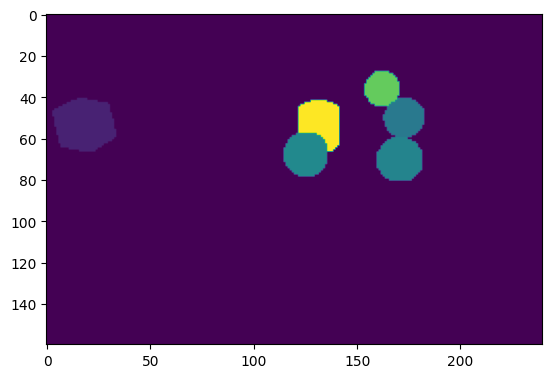

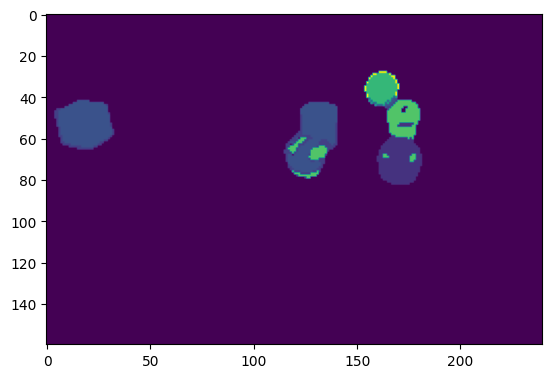

  0%|          | 1/1000 [00:00<11:20,  1.47it/s, Per frame Loss=0.224]

torch.Size([1, 49, 160, 240]) torch.Size([1, 160, 240])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor(0.0377, device='cuda:0')
tensor(False, device='cuda:0')


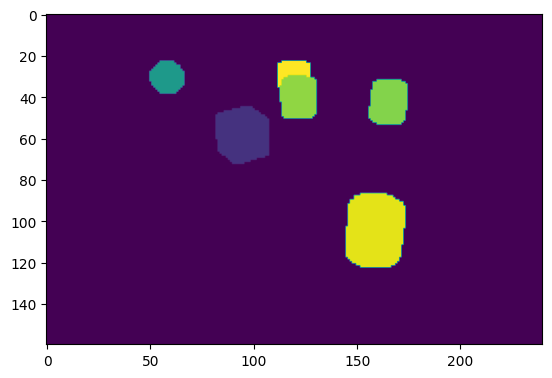

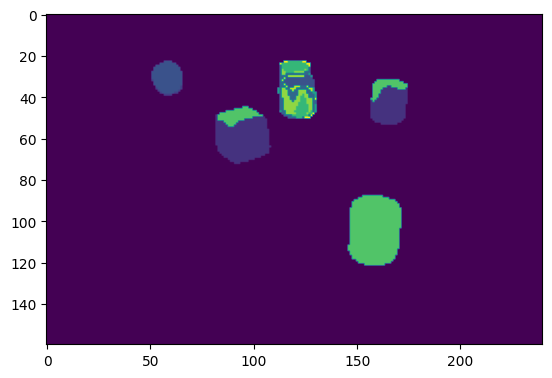

  0%|          | 2/1000 [00:01<10:36,  1.57it/s, Per frame Loss=0.205]

torch.Size([1, 49, 160, 240]) torch.Size([1, 160, 240])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor(0.0206, device='cuda:0')
tensor(False, device='cuda:0')


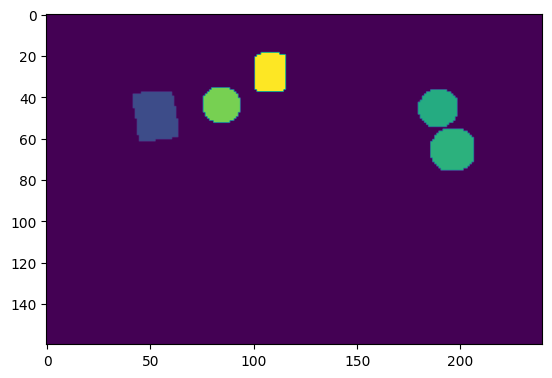

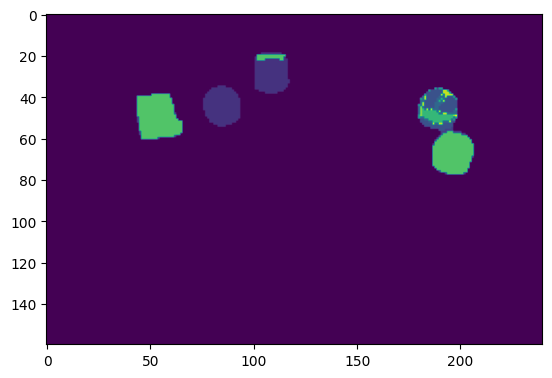

  0%|          | 3/1000 [00:01<10:25,  1.59it/s, Per frame Loss=0.189]

torch.Size([1, 49, 160, 240]) torch.Size([1, 160, 240])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor(0.0219, device='cuda:0')
tensor(False, device='cuda:0')


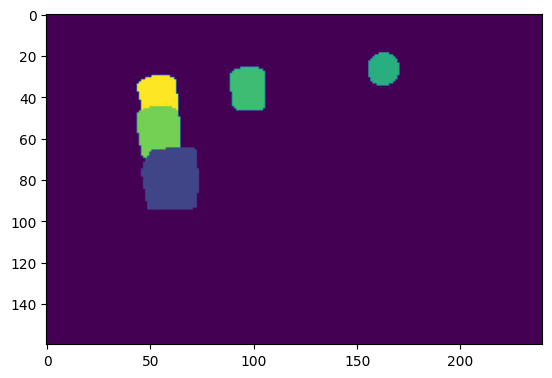

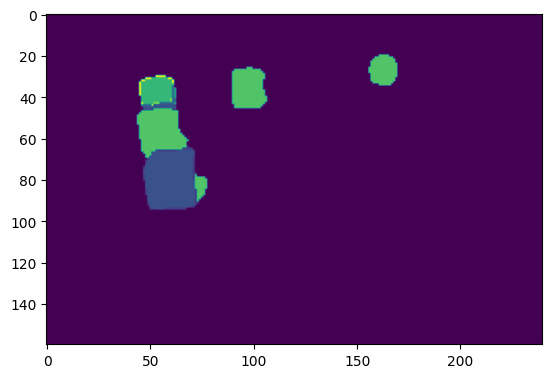

  0%|          | 4/1000 [00:02<10:28,  1.58it/s, Per frame Loss=0.185]

torch.Size([1, 49, 160, 240]) torch.Size([1, 160, 240])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor(0.0274, device='cuda:0')
tensor(False, device='cuda:0')


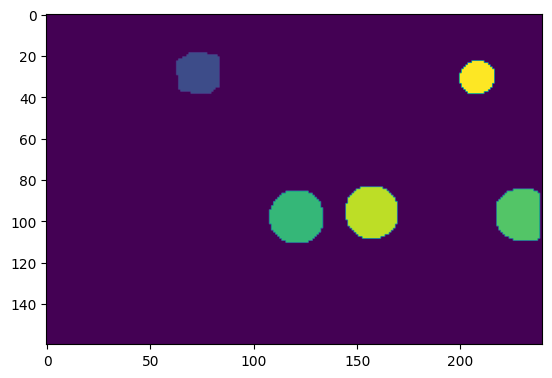

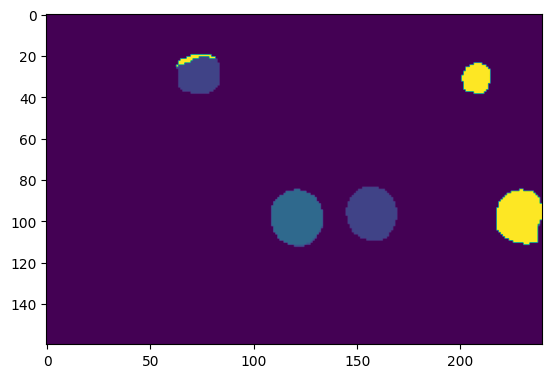

  0%|          | 5/1000 [00:03<10:33,  1.57it/s, Per frame Loss=0.117]

torch.Size([1, 49, 160, 240]) torch.Size([1, 160, 240])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor(0.0200, device='cuda:0')
tensor(False, device='cuda:0')


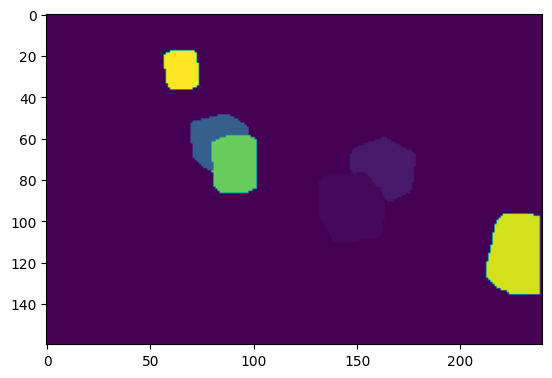

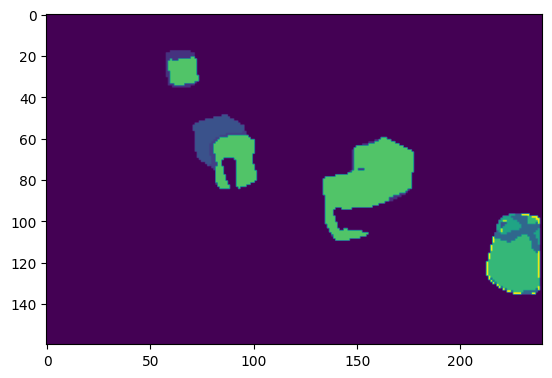

  1%|          | 6/1000 [00:03<10:26,  1.59it/s, Per frame Loss=0.21] 

torch.Size([1, 49, 160, 240]) torch.Size([1, 160, 240])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor(0.0520, device='cuda:0')
tensor(False, device='cuda:0')


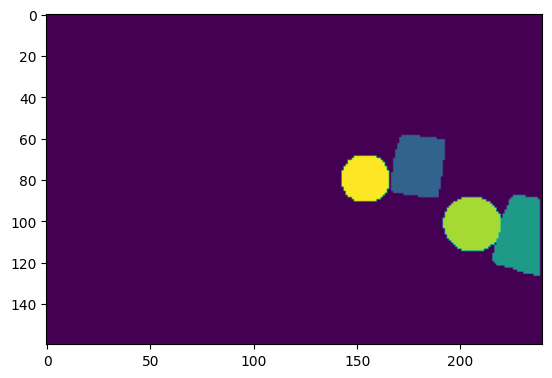

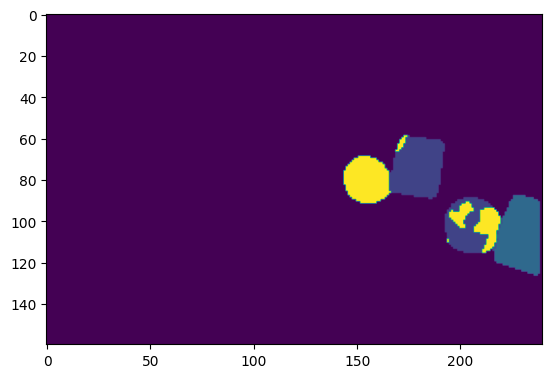

  1%|          | 7/1000 [00:04<10:28,  1.58it/s, Per frame Loss=0.114]

torch.Size([1, 49, 160, 240]) torch.Size([1, 160, 240])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor(0.0203, device='cuda:0')
tensor(False, device='cuda:0')


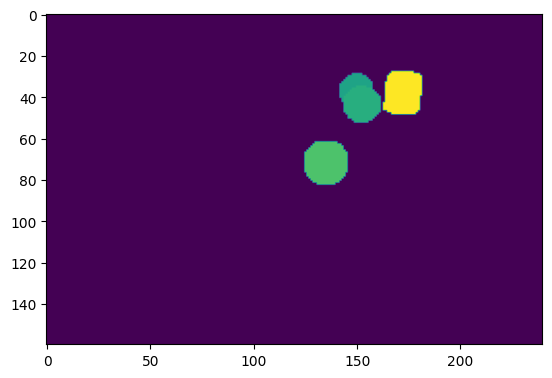

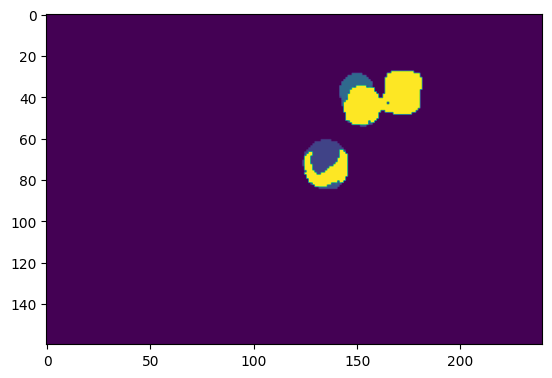

  1%|          | 8/1000 [00:05<10:34,  1.56it/s, Per frame Loss=0.137]

torch.Size([1, 49, 160, 240]) torch.Size([1, 160, 240])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor(0.0298, device='cuda:0')
tensor(False, device='cuda:0')


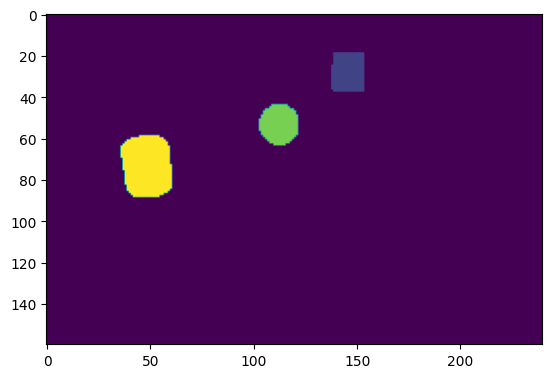

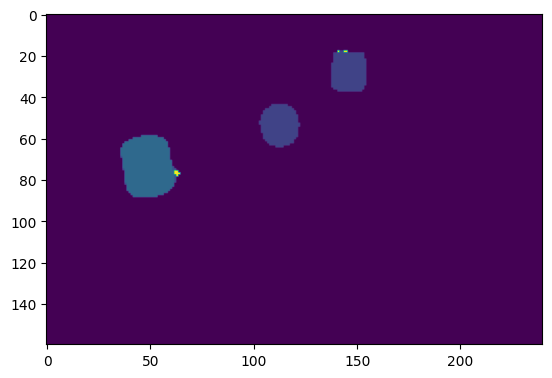

  1%|          | 9/1000 [00:05<10:30,  1.57it/s, Per frame Loss=0.115]

torch.Size([1, 49, 160, 240]) torch.Size([1, 160, 240])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor(0.0315, device='cuda:0')
tensor(False, device='cuda:0')


KeyboardInterrupt: 

In [25]:
test(downstream_model, MCJepa_model, 1, val_dataloader, criterion)

In [40]:
def real_test(downstream_model, JepaModel, epochs, dataloader, criterion, optimizer, scale = 0.1):
    

    train_losses = []

    best_loss = float("inf")
    best_model = downstream_model.state_dict()

    for _ in range(epochs):
        total_train_loss = 0.0

        pbar = tqdm(dataloader, leave=False)

        for j,batch in enumerate(pbar):
          
            frame_list, mask_list = batch[0], batch[1] # TODO
            total_train_loss = 0.0
            X_tconcat = None
            I_hat_t = None
            I_hat_tnext = None
            I_hat_t = None
            
#             final_flow = 0.0
            for i in range(11):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
                mask_list = mask_list.type(torch.LongTensor).to(device)


                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext = JepaModel(img1, img2)
#                 final_flow = JepaModel.deconv1(f_t_tnext[0])*20.0 + scale*final_flow
                
            
            mask_pred = downstream_model(frame_list[11].to(device))
            mask_pred_ = downstream_model(frame_list[11].to(device))
            
            for i in range(11):
                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext = JepaModel(I_hat_t, I_hat_tnext)
#                 print(f_t_tnext[0].shape, mask_pred.shape)
                flow = JepaModel.deconv1(f_t_tnext[0]) 
                flow *= 1.25
                mask_pred = warp(mask_pred, flow)

#             mask_pred = warp(mask_pred, flow)
            
            plt.imshow(unnormalize(img1[0]).permute(1, 2, 0).cpu())
            plt.show()
            plt.imshow(unnormalize(I_hat_tnext[0]).permute(1, 2, 0).cpu())
            plt.show()
#             mask_pred = downstream_model(I_hat_tnext)

#             print(f_t_tnext)
            print(jaccard(mask_pred, mask_list[:,21]))
            print((torch.argmax(mask_pred[0], dim=0) == torch.argmax(mask_pred_[0].cpu())).all())
            
            plt.imshow(mask_list[0][21].cpu())
            plt.show()
            plt.imshow(torch.argmax(mask_pred[0].cpu(), dim=0))
            plt.show()
            plt.imshow(torch.argmax(mask_pred_[0].cpu(), dim=0))
            plt.show()
            loss = criterion(mask_pred, mask_list[:,21])
            total_train_loss += loss.item()

            pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1)})

  0%|          | 0/1000 [00:00<?, ?it/s]

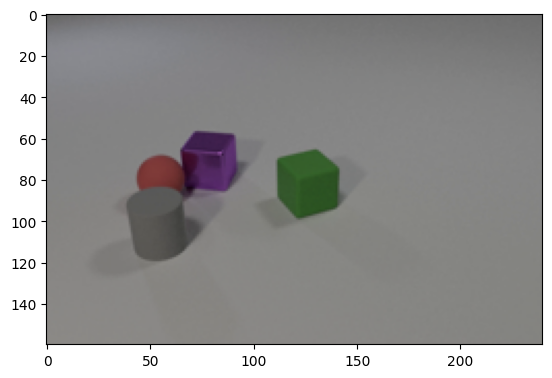

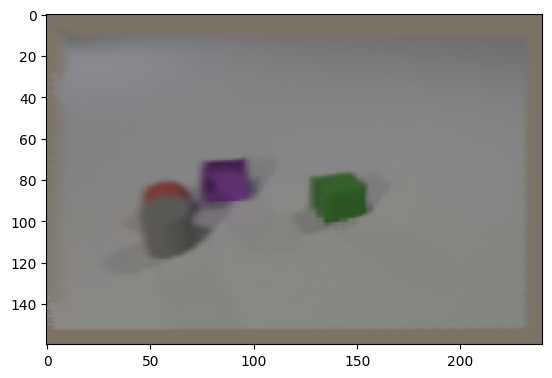

tensor(0.0180, device='cuda:0')
tensor(False, device='cuda:0')


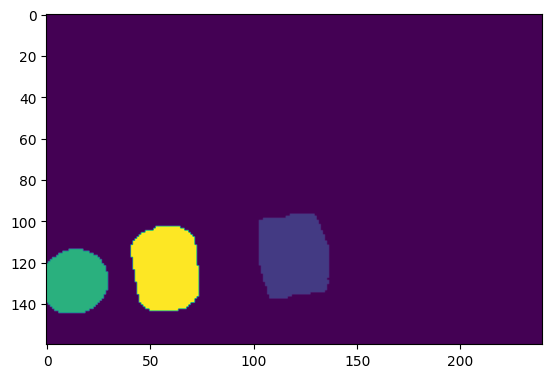

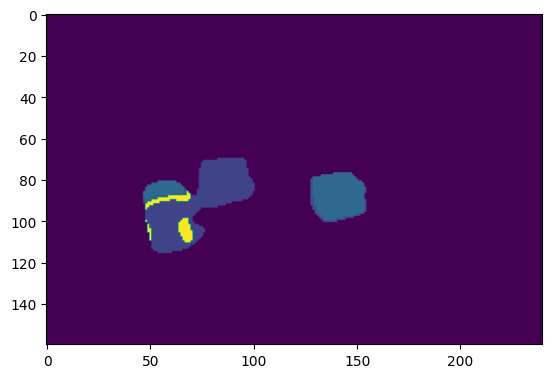

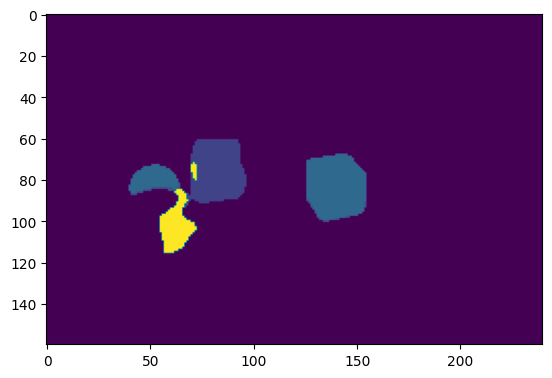

  0%|          | 1/1000 [00:01<22:19,  1.34s/it, Per frame Loss=0.655]

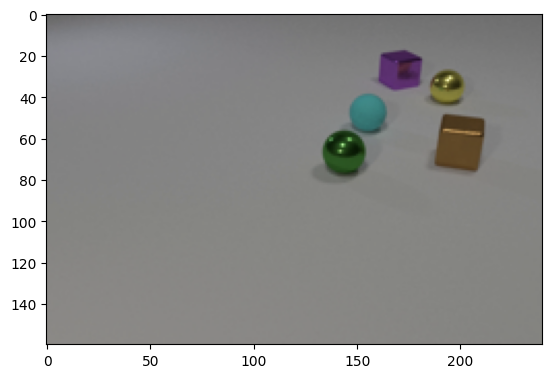

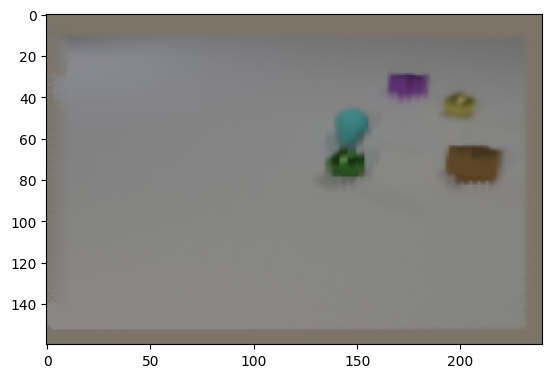

tensor(0.0195, device='cuda:0')
tensor(False, device='cuda:0')


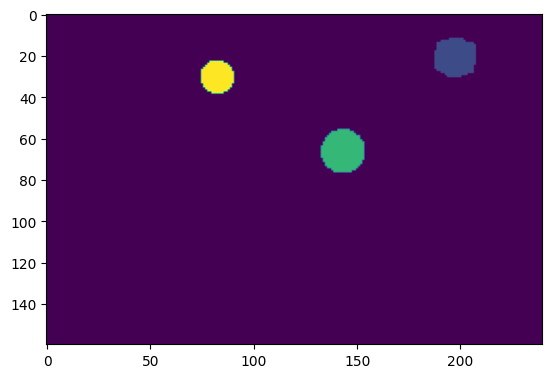

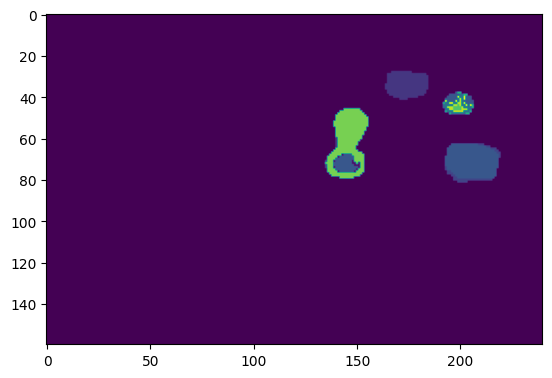

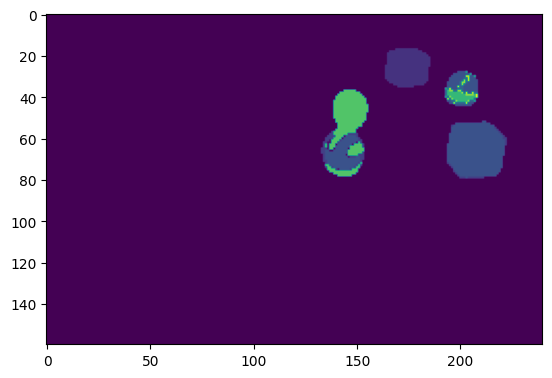

  0%|          | 2/1000 [00:02<22:23,  1.35s/it, Per frame Loss=0.345]

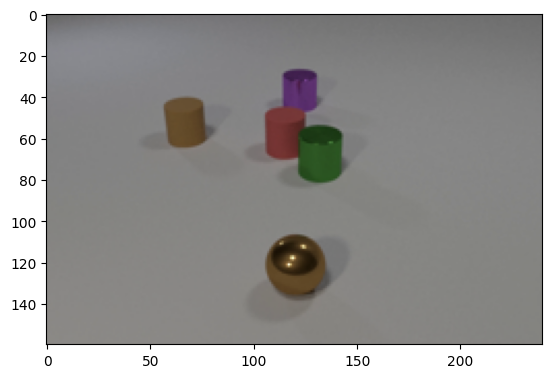

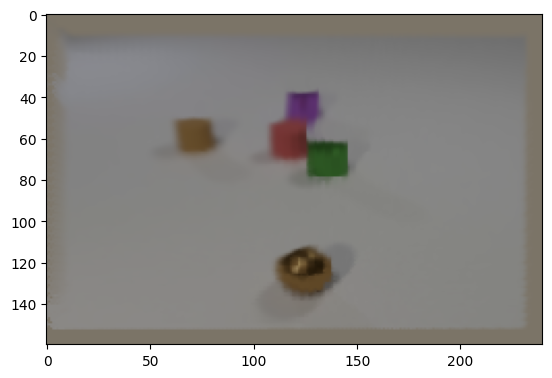

tensor(0.0186, device='cuda:0')
tensor(False, device='cuda:0')


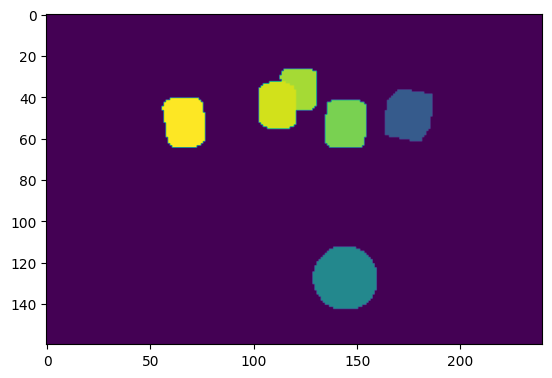

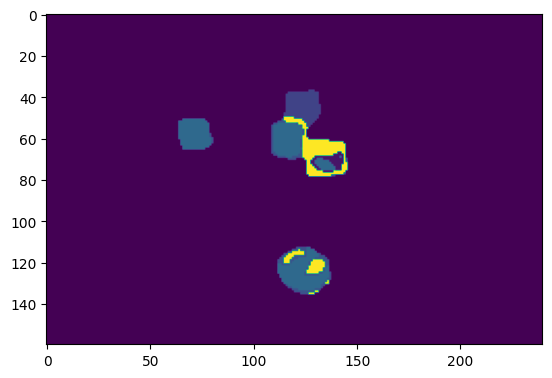

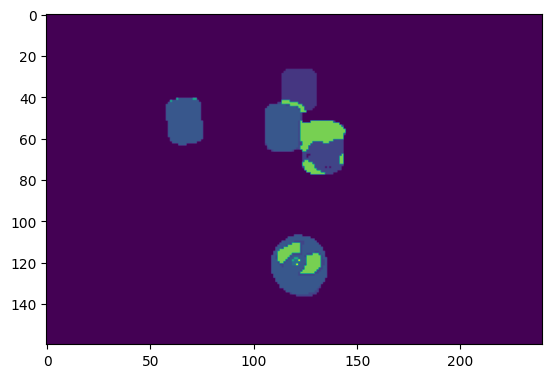

  0%|          | 3/1000 [00:04<22:36,  1.36s/it, Per frame Loss=0.688]

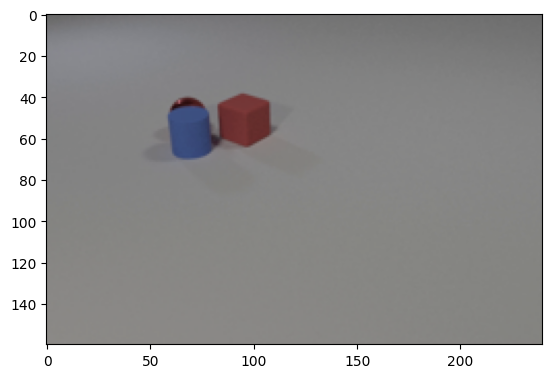

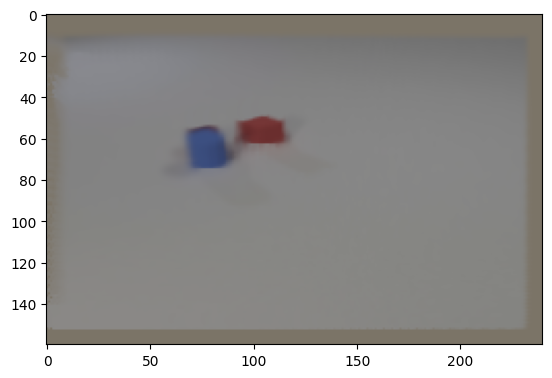

tensor(0.0189, device='cuda:0')
tensor(False, device='cuda:0')


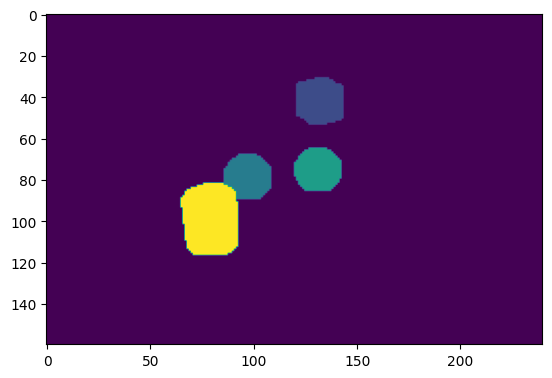

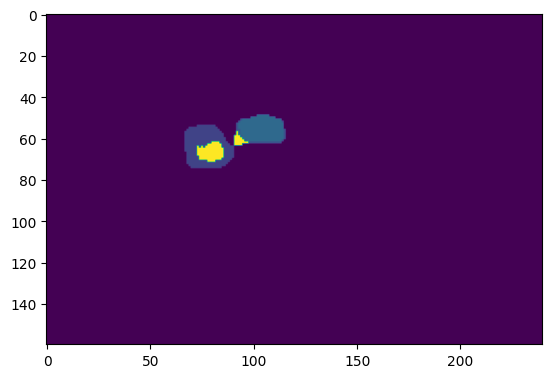

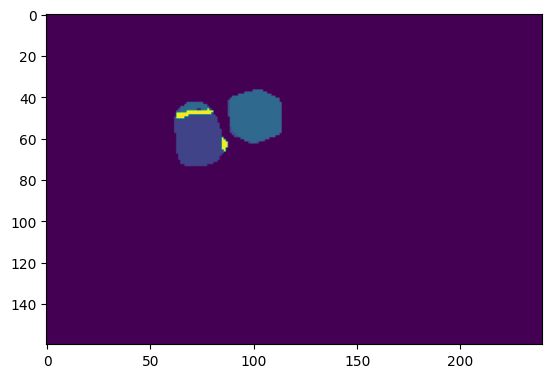

  0%|          | 4/1000 [00:05<22:25,  1.35s/it, Per frame Loss=0.635]

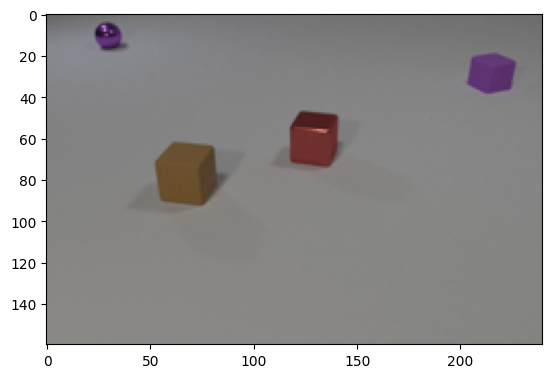

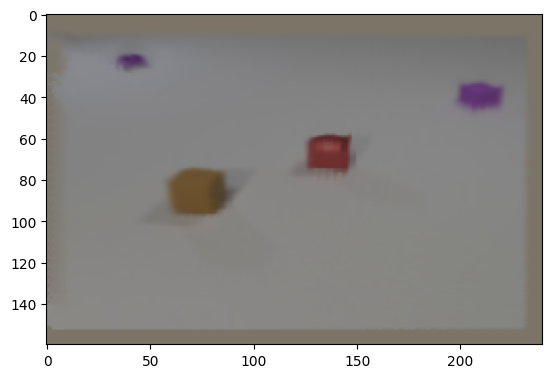

tensor(0.0183, device='cuda:0')
tensor(False, device='cuda:0')


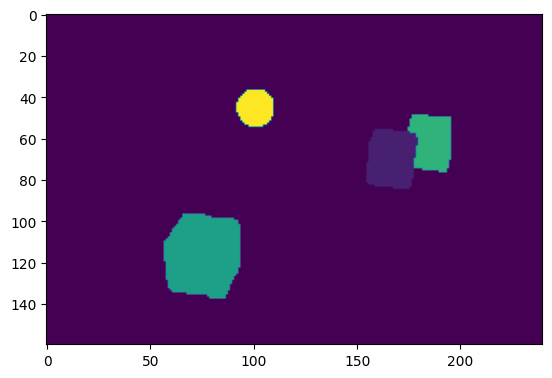

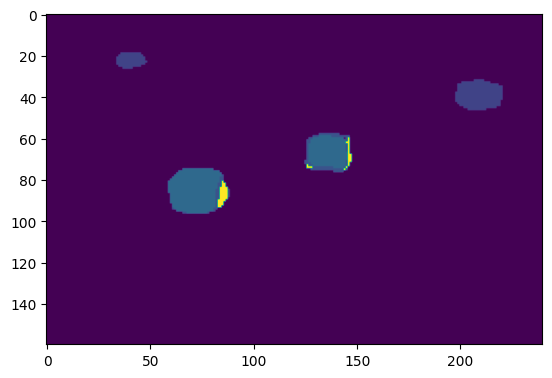

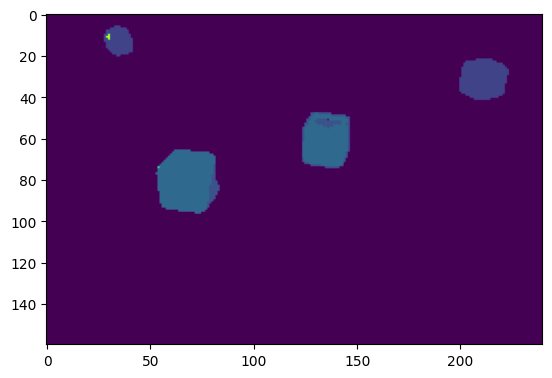

  0%|          | 5/1000 [00:06<22:29,  1.36s/it, Per frame Loss=0.702]

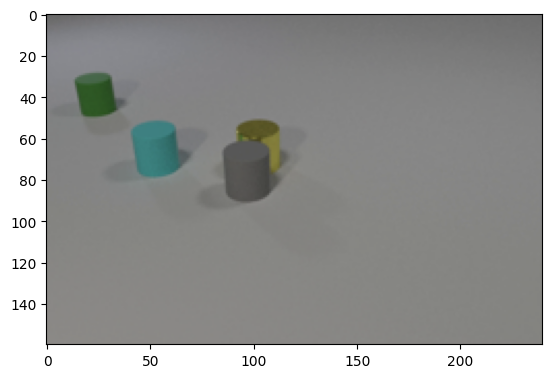

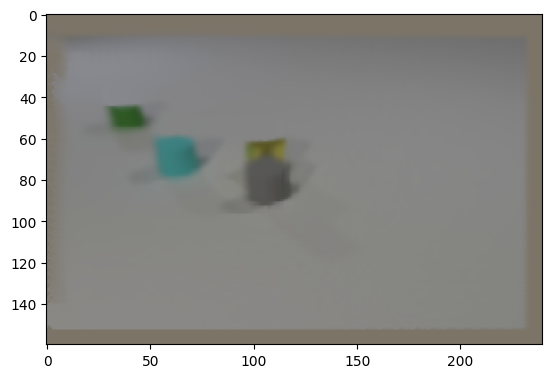

tensor(0.0191, device='cuda:0')
tensor(False, device='cuda:0')


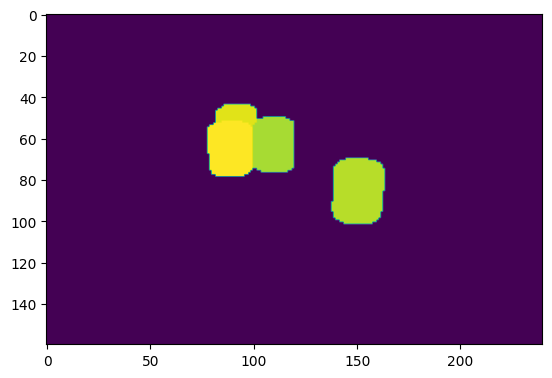

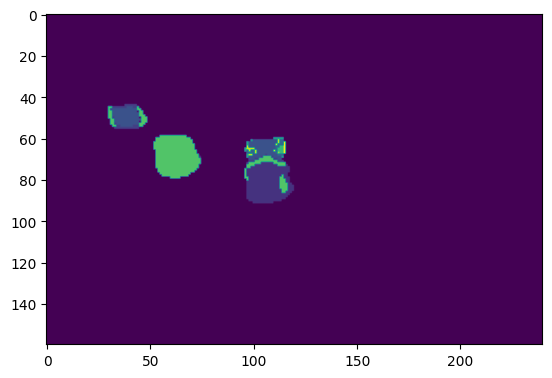

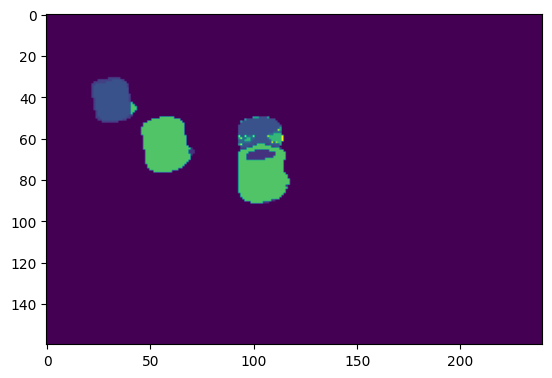

  1%|          | 6/1000 [00:08<22:22,  1.35s/it, Per frame Loss=0.428]

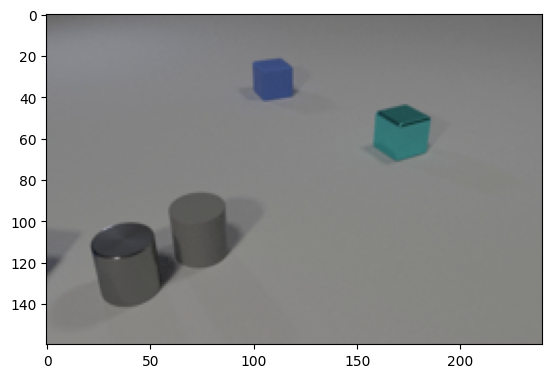

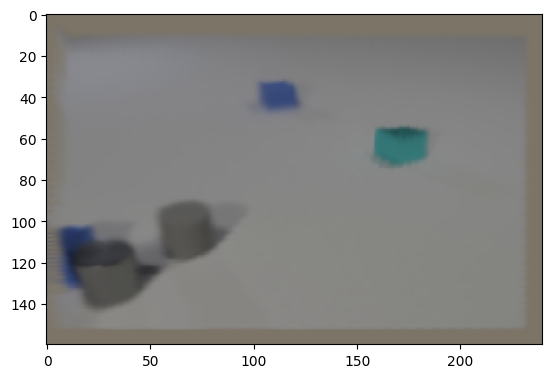

tensor(0.0187, device='cuda:0')
tensor(False, device='cuda:0')


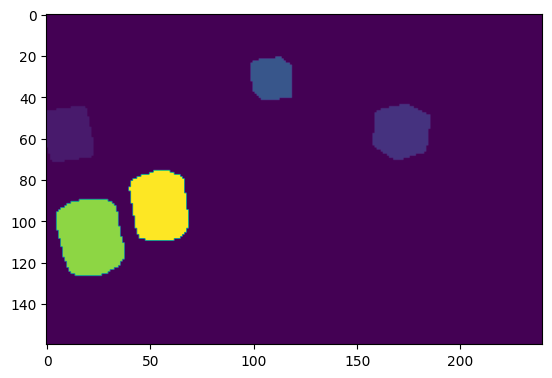

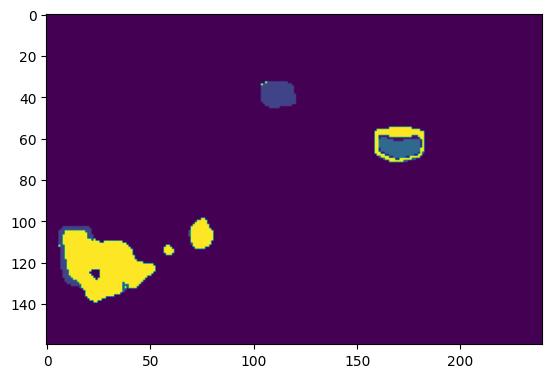

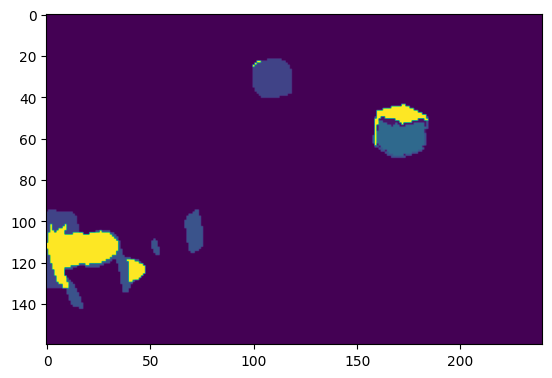

  1%|          | 7/1000 [00:09<22:11,  1.34s/it, Per frame Loss=0.566]

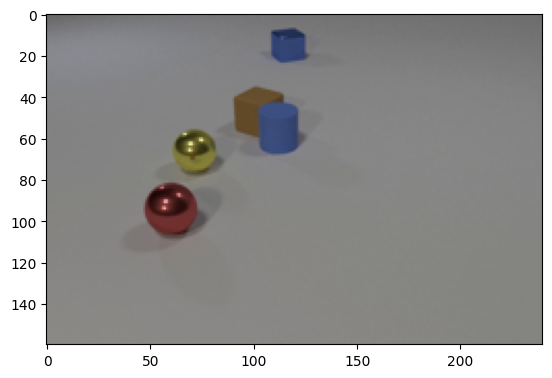

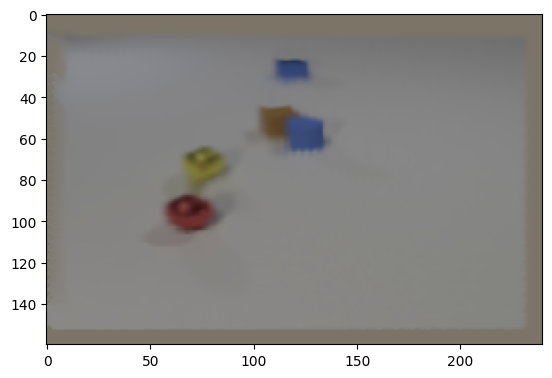

tensor(0.0191, device='cuda:0')
tensor(False, device='cuda:0')


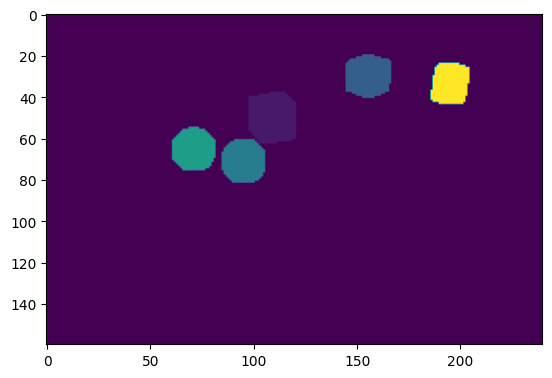

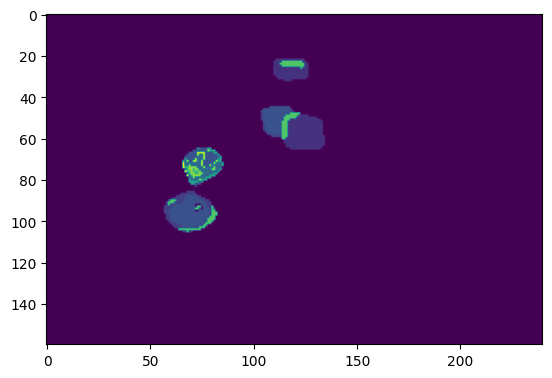

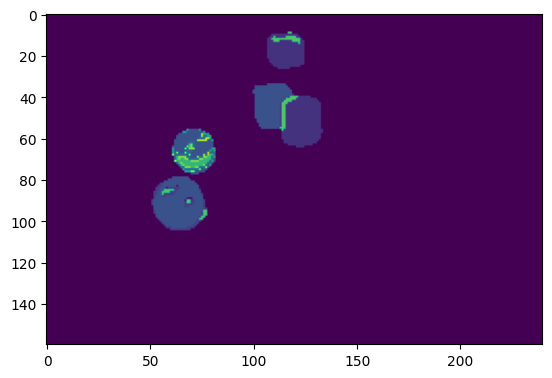

  1%|          | 8/1000 [00:10<22:04,  1.34s/it, Per frame Loss=0.83] 

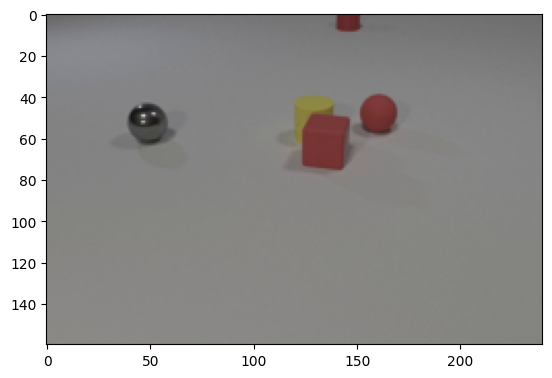

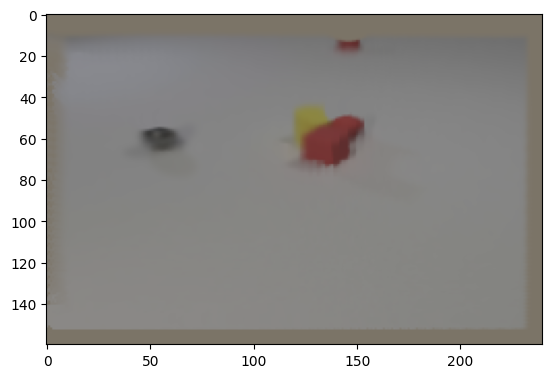

tensor(0.0193, device='cuda:0')
tensor(False, device='cuda:0')


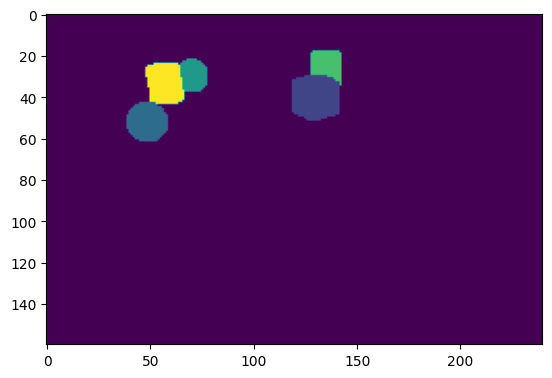

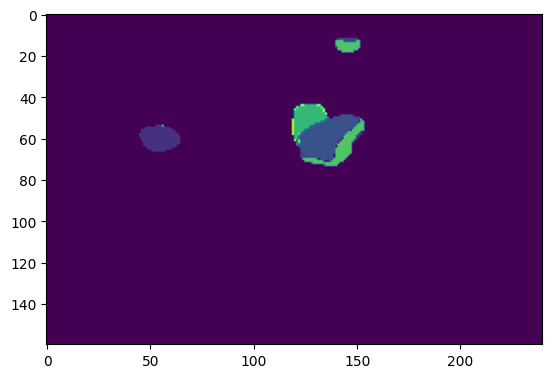

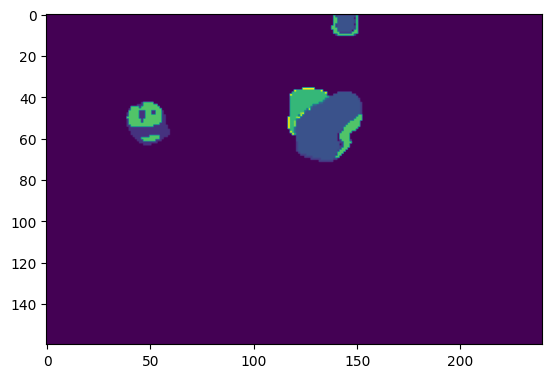

  1%|          | 9/1000 [00:12<21:57,  1.33s/it, Per frame Loss=0.334]

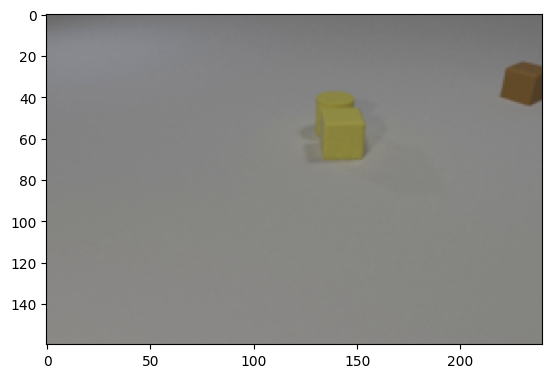

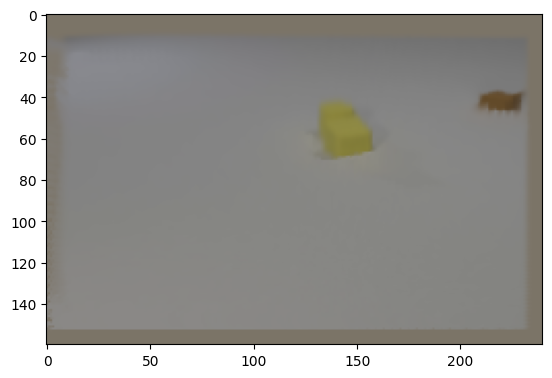

tensor(0.0232, device='cuda:0')
tensor(False, device='cuda:0')


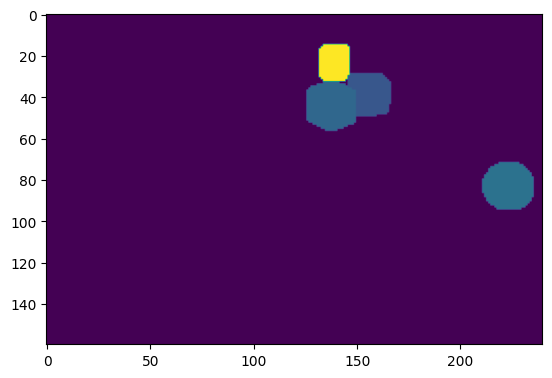

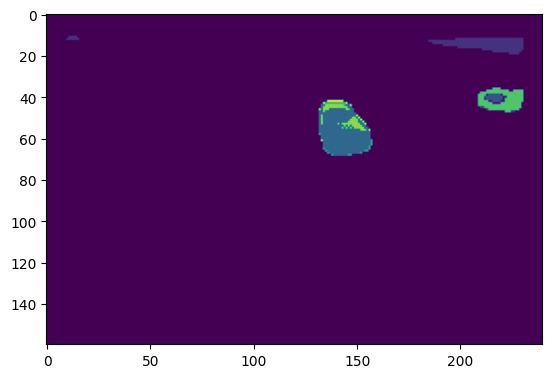

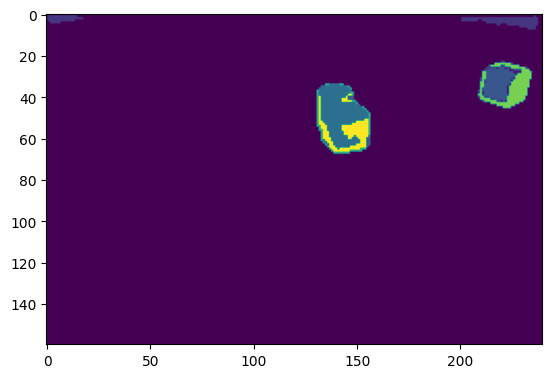

  1%|          | 10/1000 [00:13<21:50,  1.32s/it, Per frame Loss=0.384]

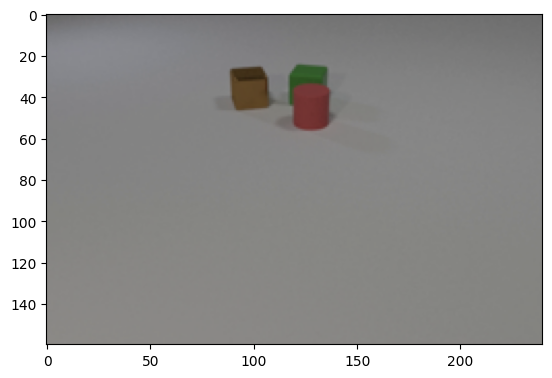

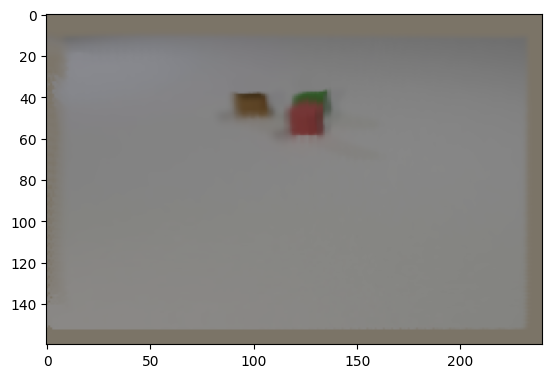

tensor(0.0199, device='cuda:0')
tensor(False, device='cuda:0')


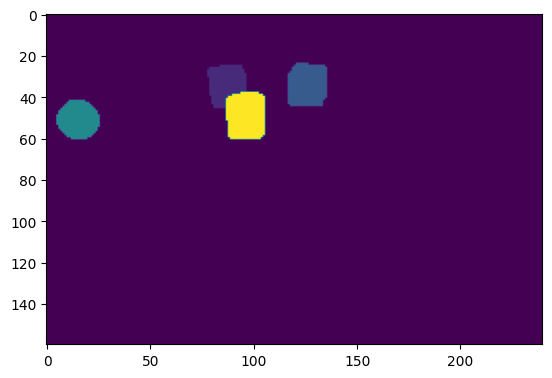

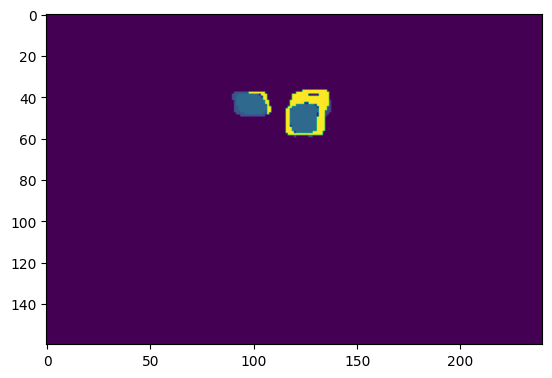

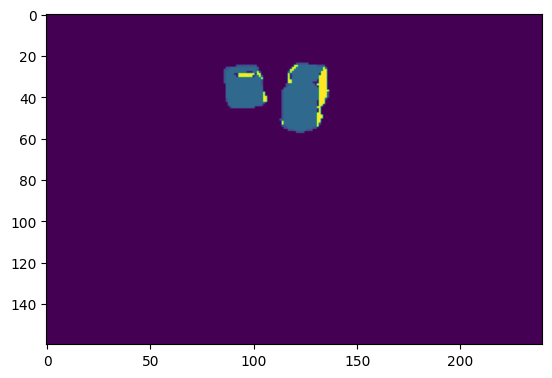

  1%|          | 11/1000 [00:14<21:50,  1.33s/it, Per frame Loss=0.373]

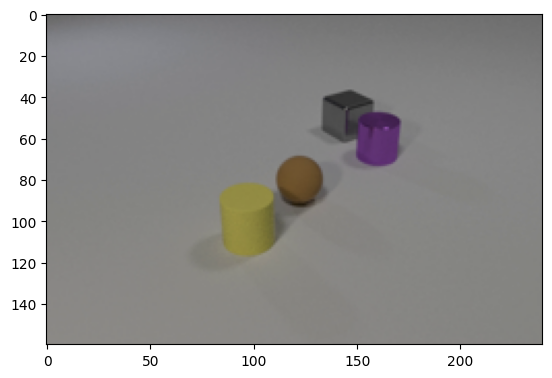

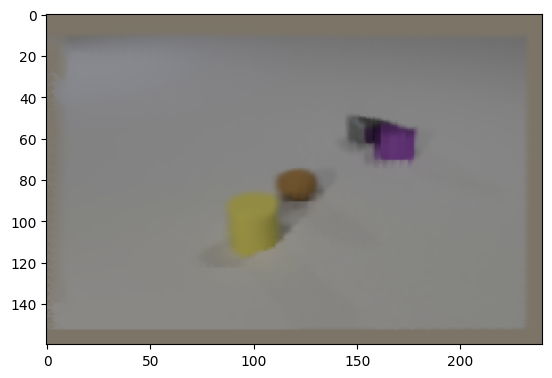

tensor(0.0193, device='cuda:0')
tensor(False, device='cuda:0')


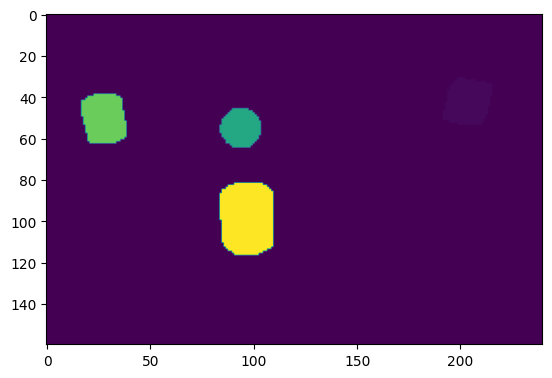

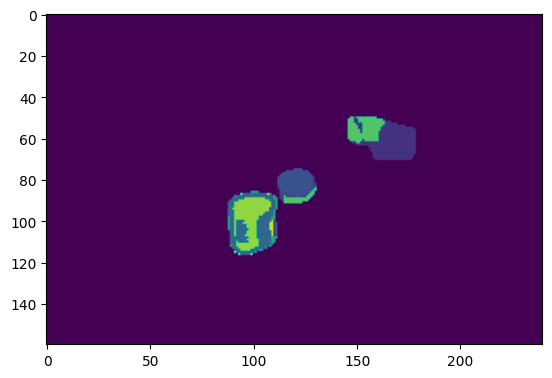

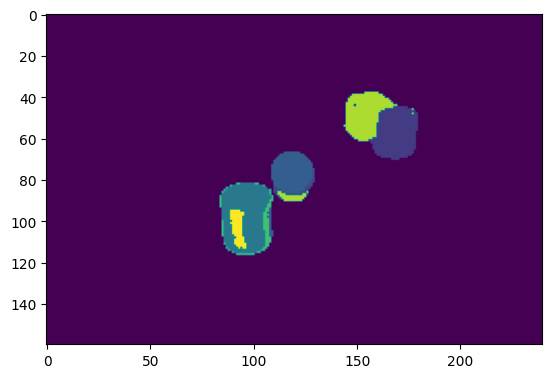

  1%|          | 12/1000 [00:16<23:13,  1.41s/it, Per frame Loss=0.381]

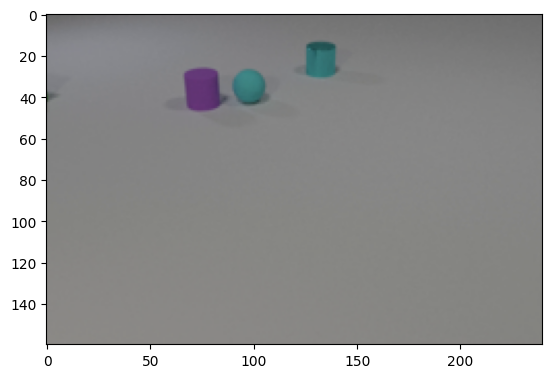

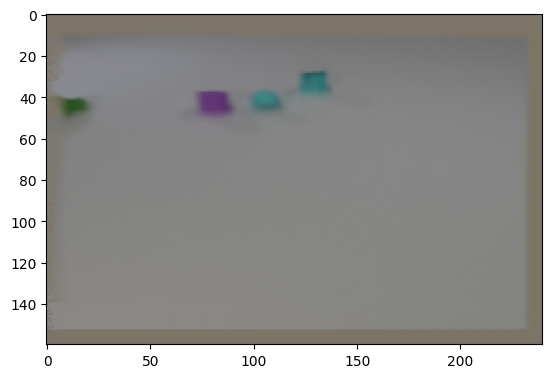

tensor(0.0198, device='cuda:0')
tensor(False, device='cuda:0')


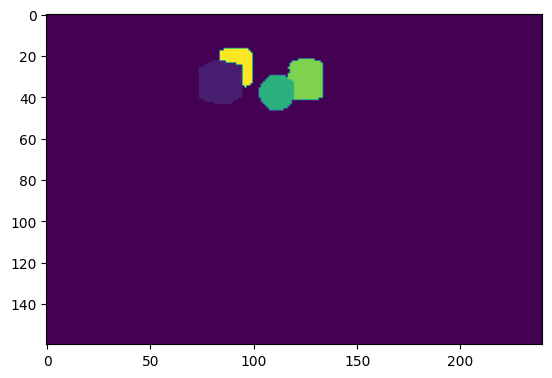

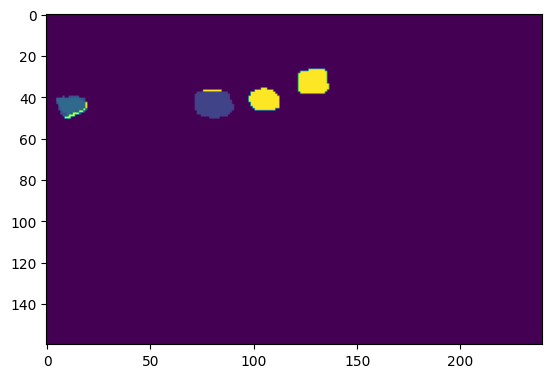

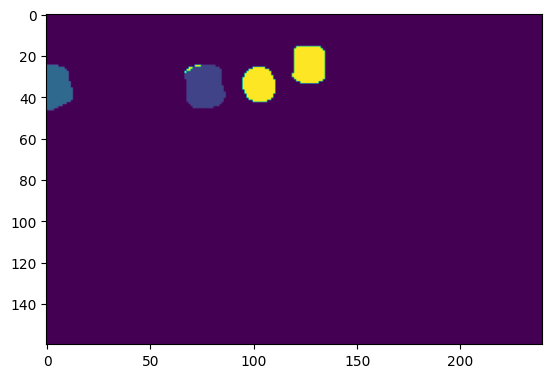

  1%|▏         | 13/1000 [00:17<22:51,  1.39s/it, Per frame Loss=0.234]

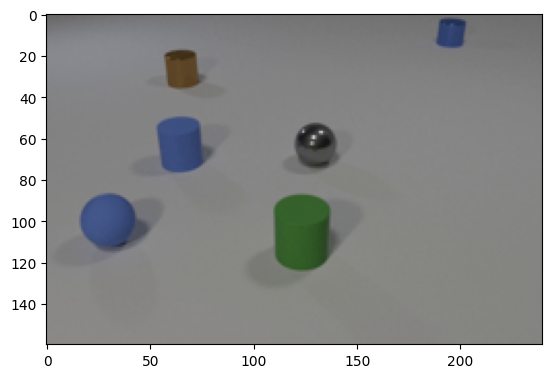

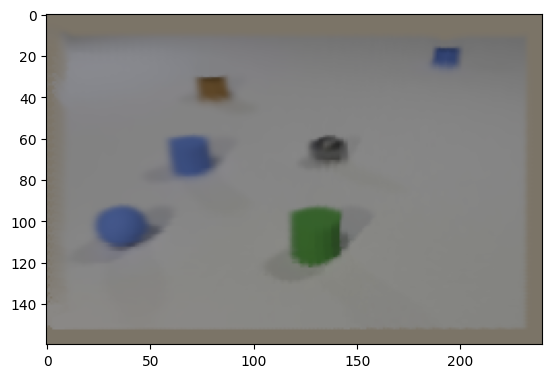

tensor(0.0186, device='cuda:0')
tensor(False, device='cuda:0')


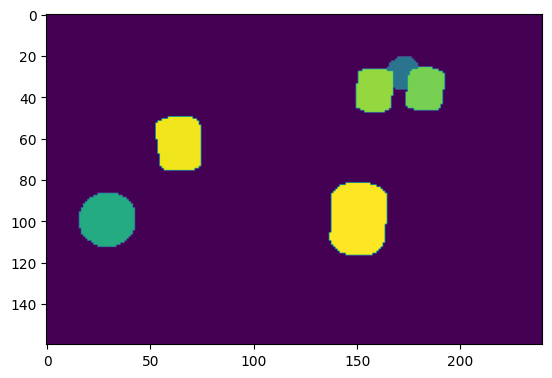

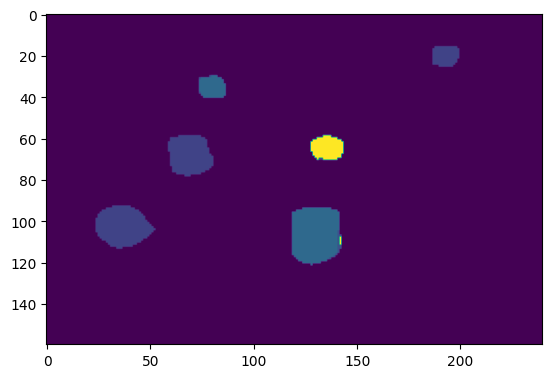

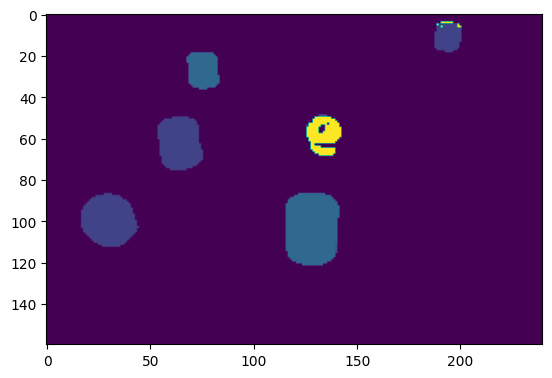

  1%|▏         | 14/1000 [00:18<22:25,  1.36s/it, Per frame Loss=1.27] 

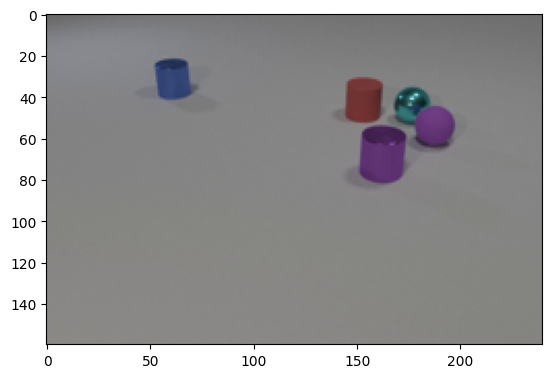

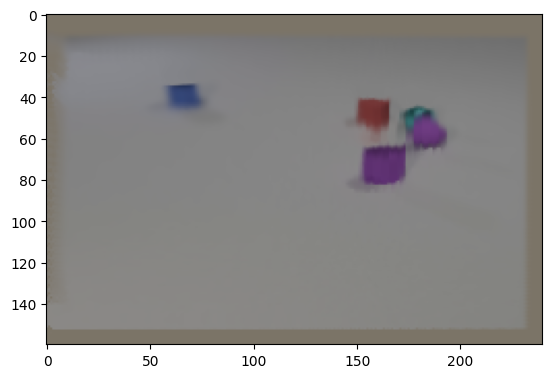

tensor(0.0222, device='cuda:0')
tensor(False, device='cuda:0')


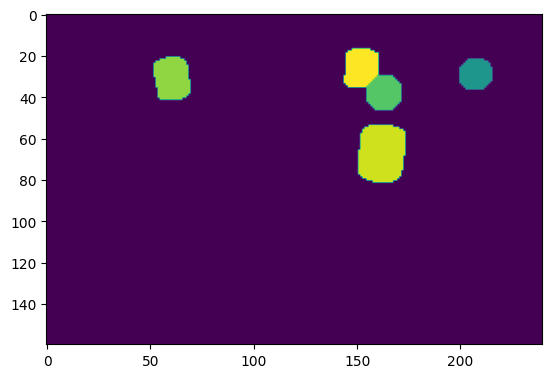

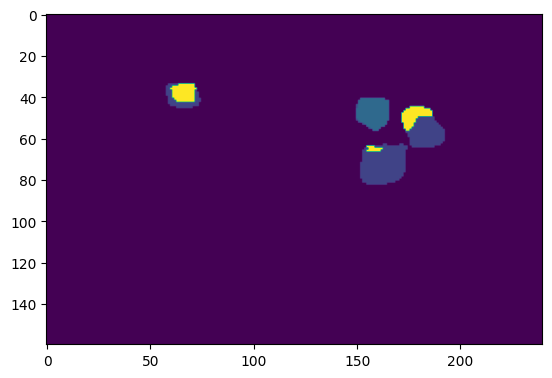

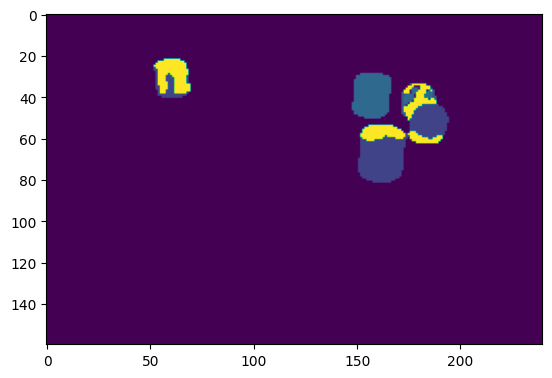

  2%|▏         | 15/1000 [00:20<22:07,  1.35s/it, Per frame Loss=0.279]

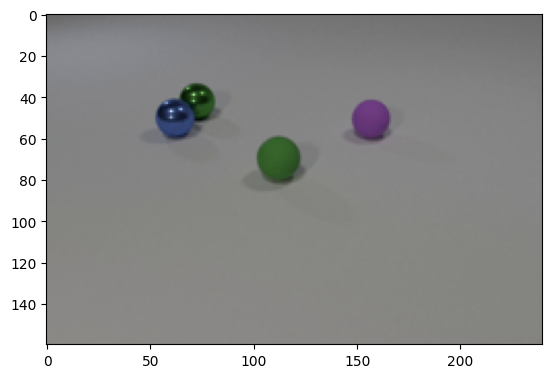

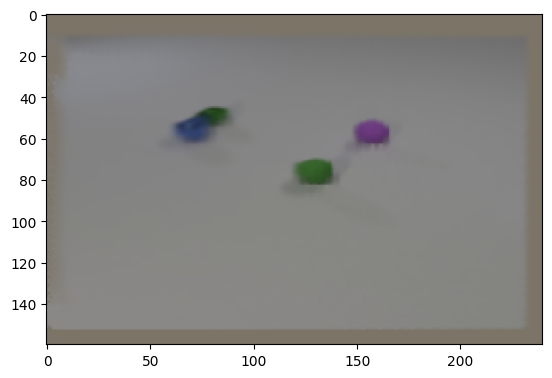

tensor(0.0196, device='cuda:0')
tensor(False, device='cuda:0')


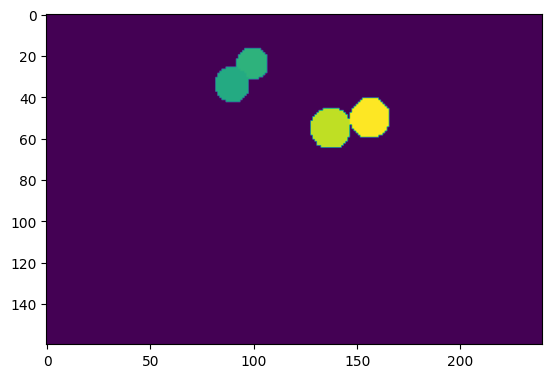

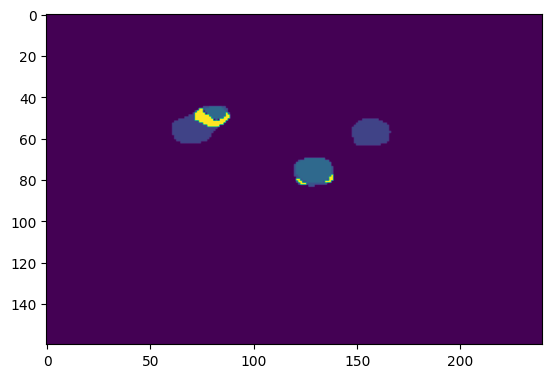

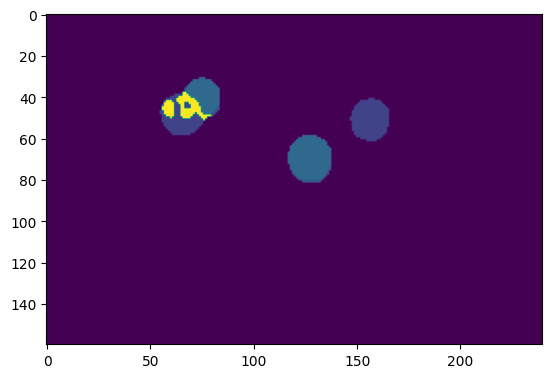

  2%|▏         | 16/1000 [00:21<21:55,  1.34s/it, Per frame Loss=0.282]

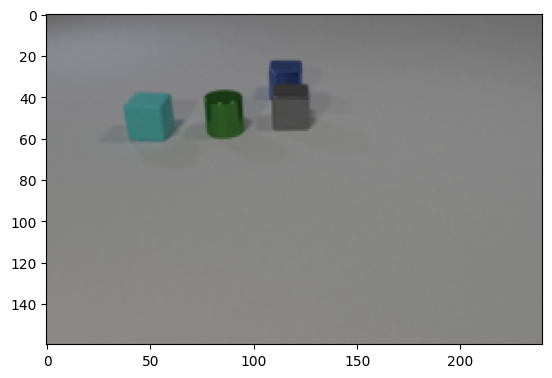

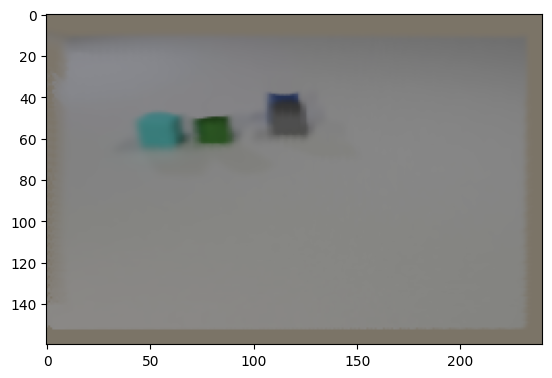

tensor(0.0192, device='cuda:0')
tensor(False, device='cuda:0')


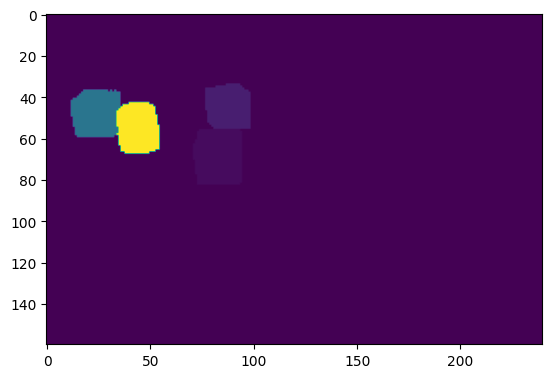

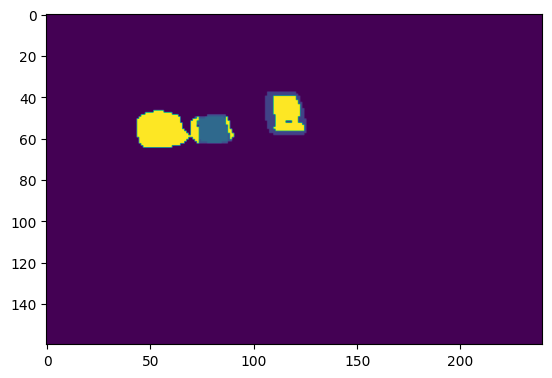

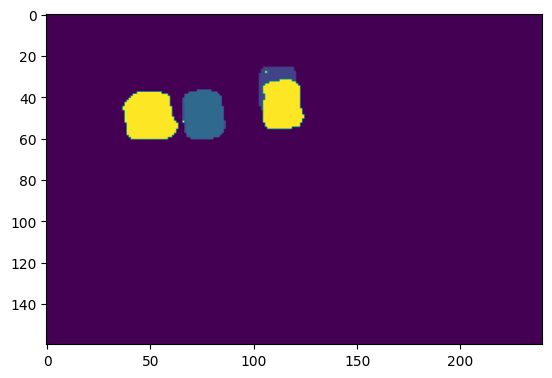

  2%|▏         | 17/1000 [00:22<21:56,  1.34s/it, Per frame Loss=0.454]

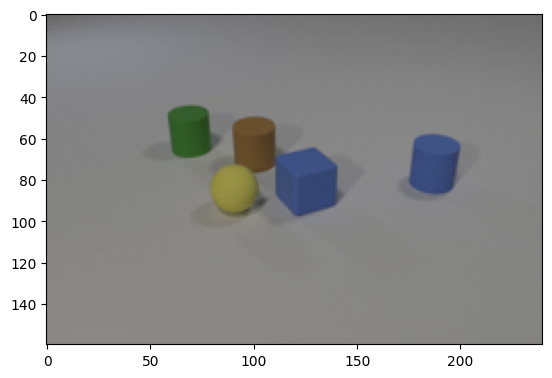

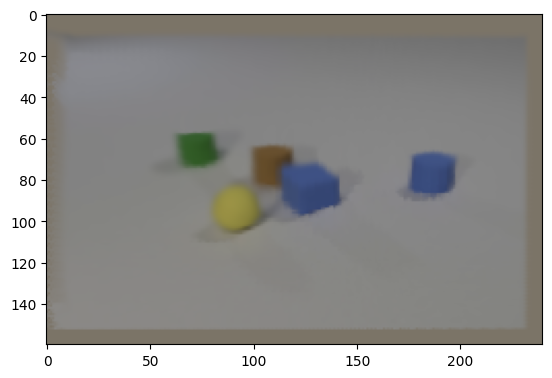

tensor(0.0186, device='cuda:0')
tensor(False, device='cuda:0')


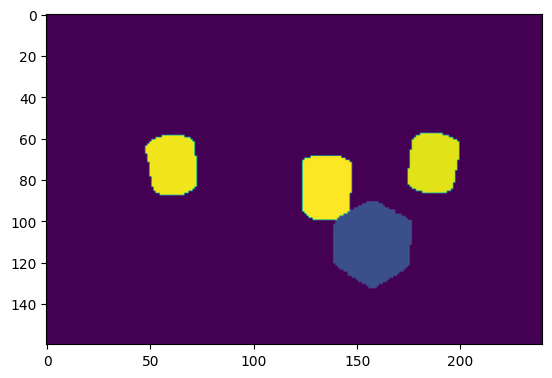

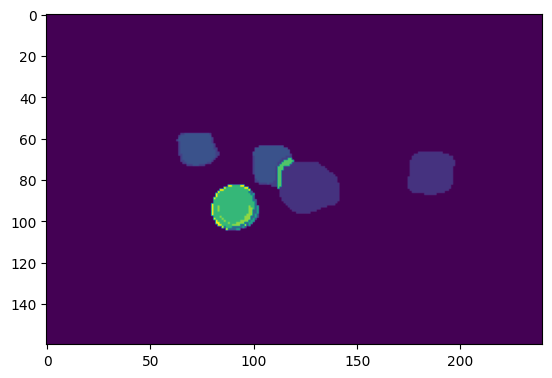

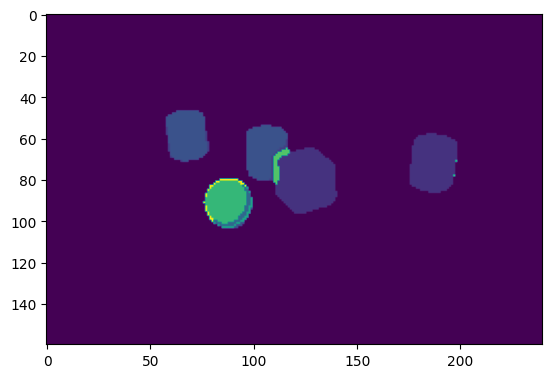

  2%|▏         | 18/1000 [00:24<22:00,  1.35s/it, Per frame Loss=0.58] 

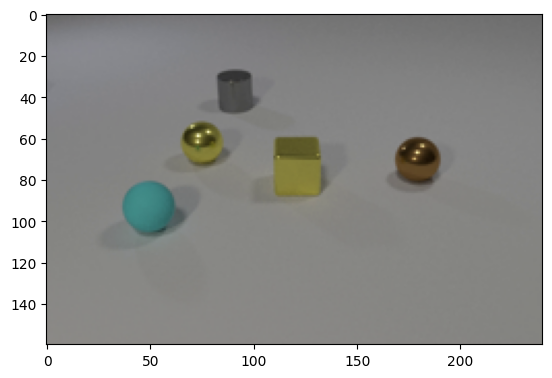

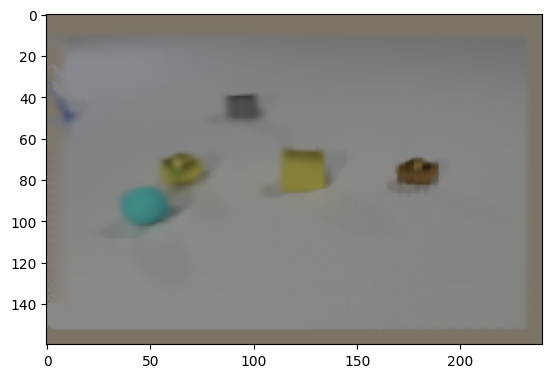

tensor(0.0191, device='cuda:0')
tensor(False, device='cuda:0')


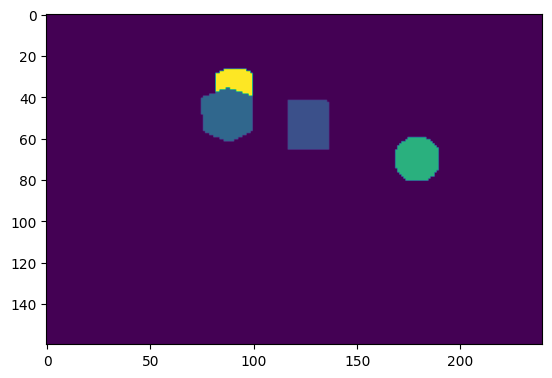

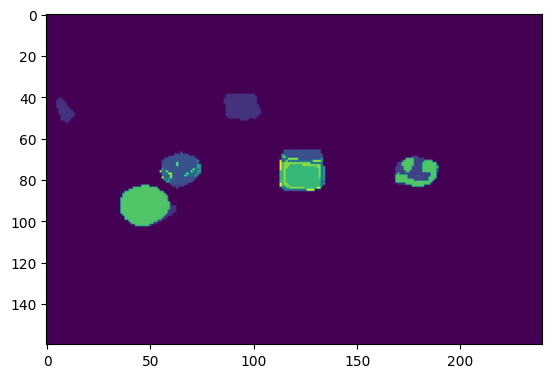

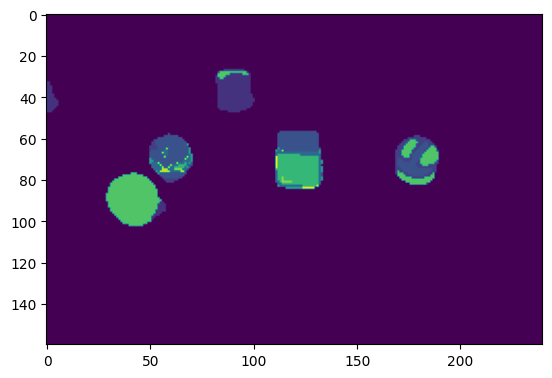

  2%|▏         | 19/1000 [00:25<21:46,  1.33s/it, Per frame Loss=0.34]

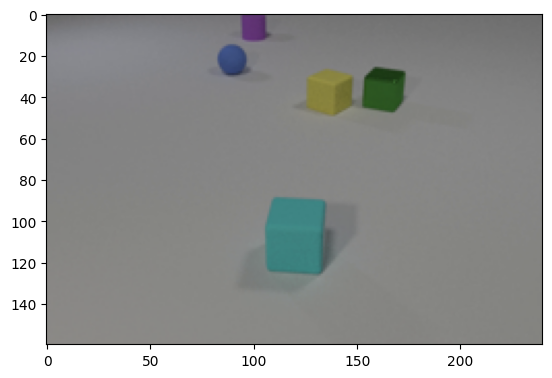

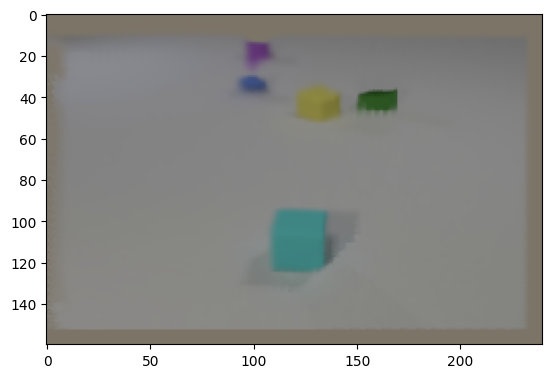

tensor(0.0191, device='cuda:0')
tensor(False, device='cuda:0')


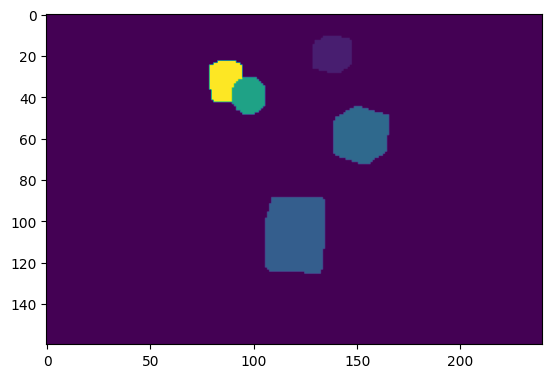

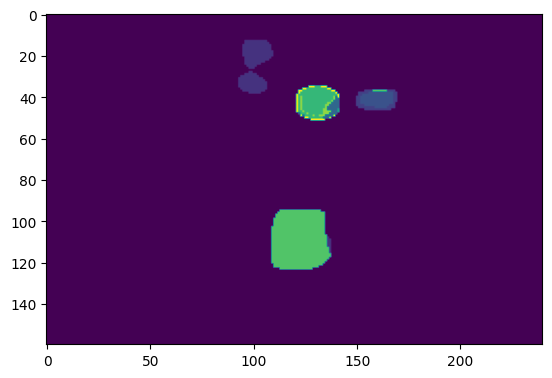

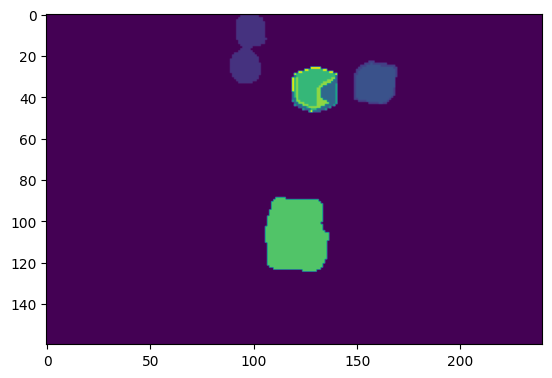

  2%|▏         | 20/1000 [00:26<21:39,  1.33s/it, Per frame Loss=0.477]

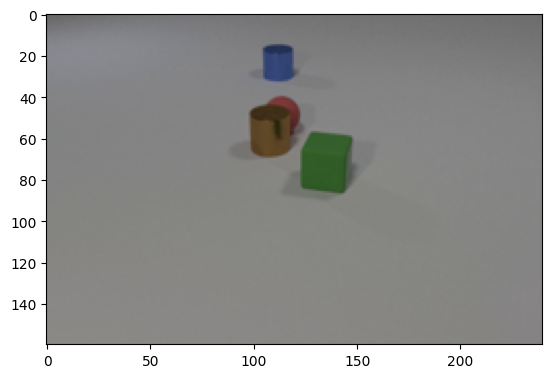

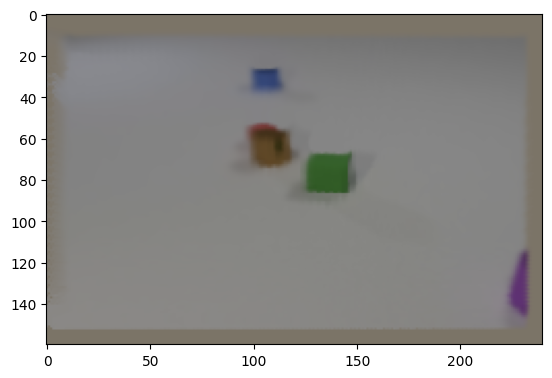

tensor(0.0262, device='cuda:0')
tensor(False, device='cuda:0')


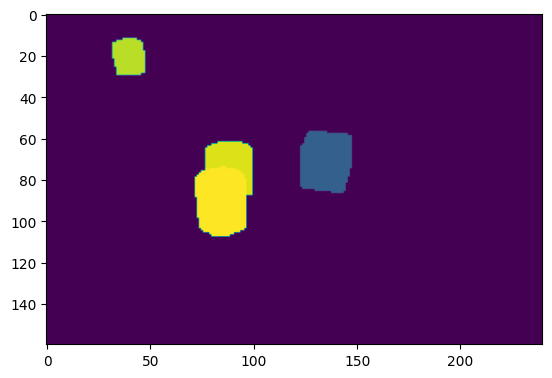

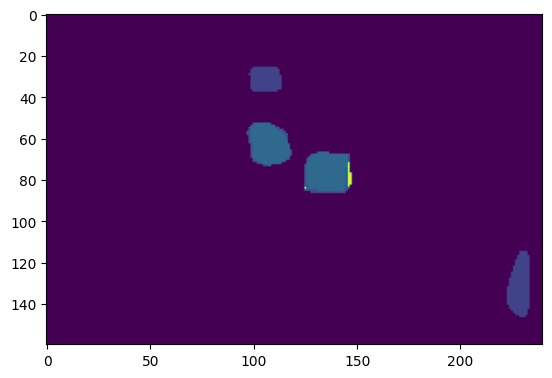

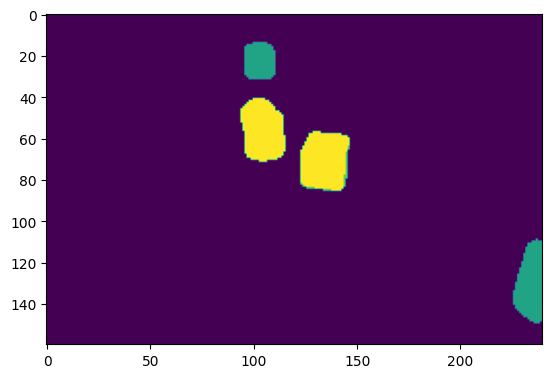

  2%|▏         | 21/1000 [00:28<21:32,  1.32s/it, Per frame Loss=0.436]

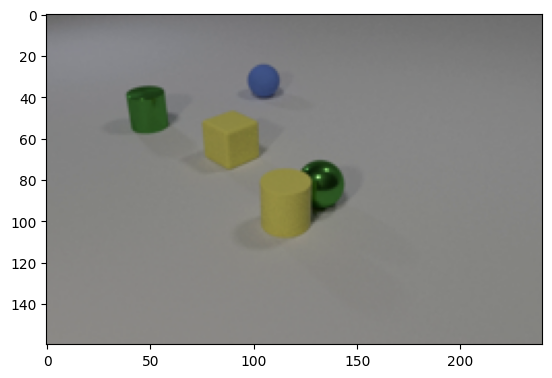

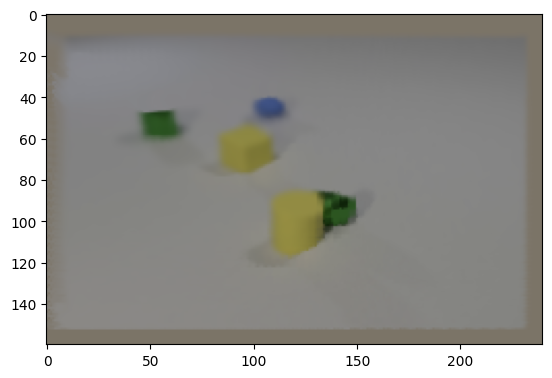

tensor(0.0202, device='cuda:0')
tensor(False, device='cuda:0')


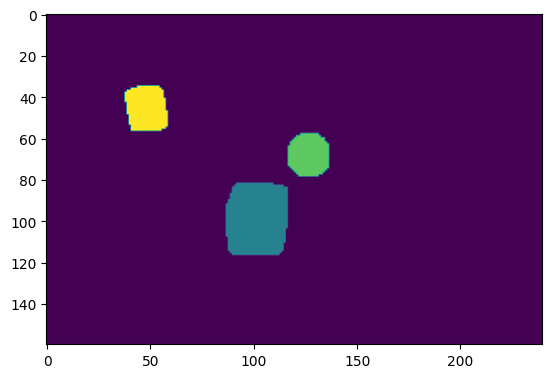

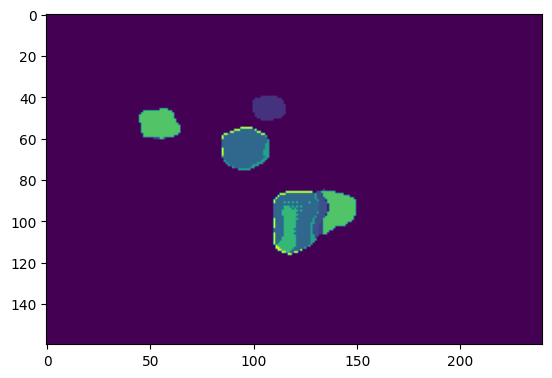

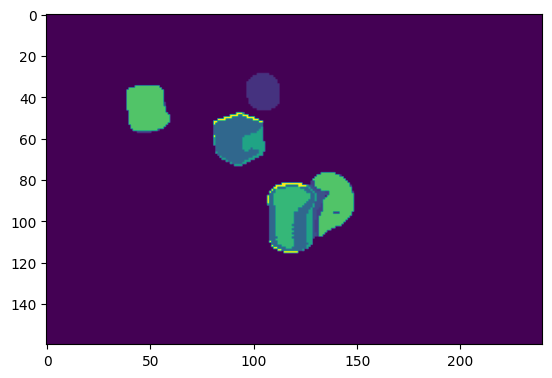

  2%|▏         | 22/1000 [00:29<21:24,  1.31s/it, Per frame Loss=0.271]

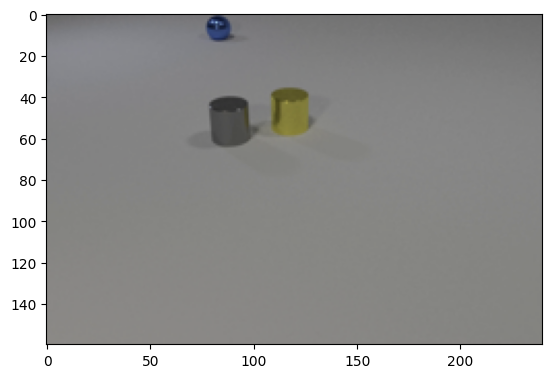

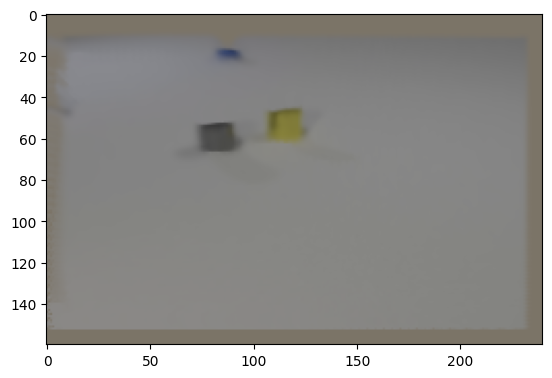

tensor(0.0196, device='cuda:0')
tensor(False, device='cuda:0')


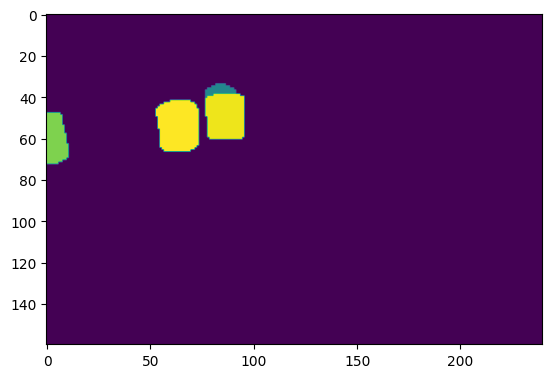

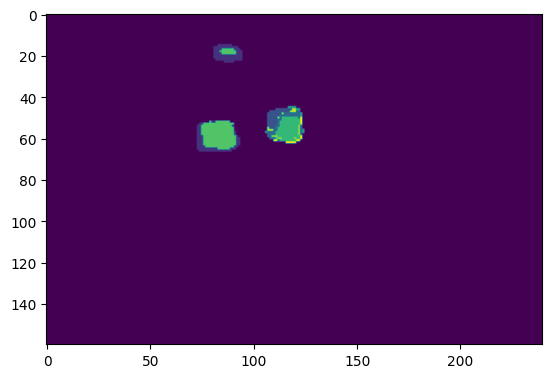

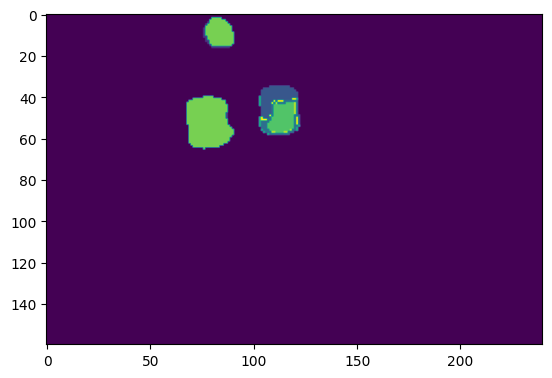

  2%|▏         | 23/1000 [00:30<21:22,  1.31s/it, Per frame Loss=0.266]

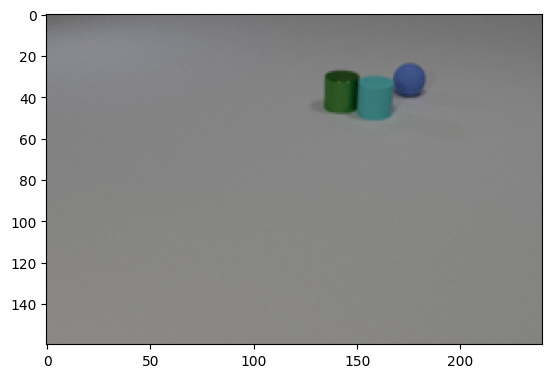

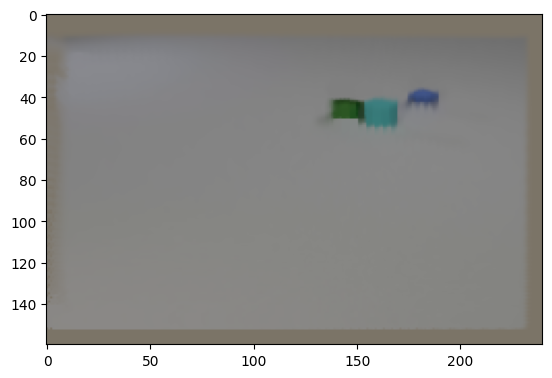

tensor(0.0198, device='cuda:0')
tensor(False, device='cuda:0')


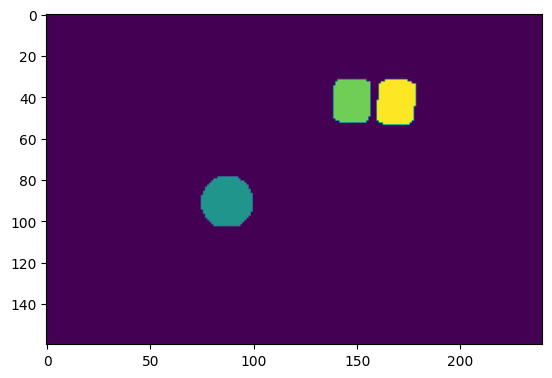

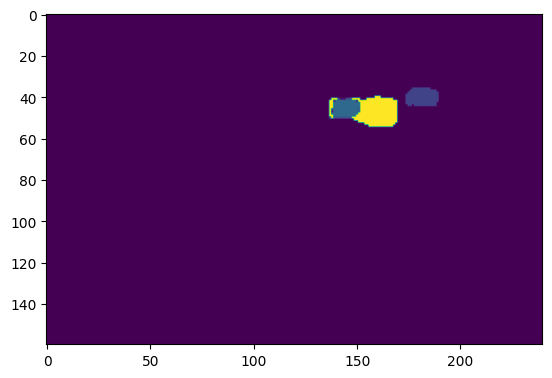

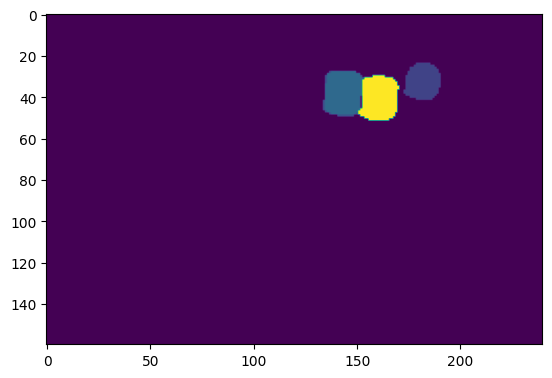

  2%|▏         | 24/1000 [00:32<21:22,  1.31s/it, Per frame Loss=0.25] 

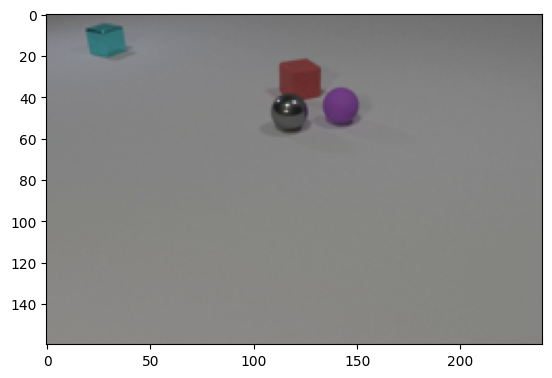

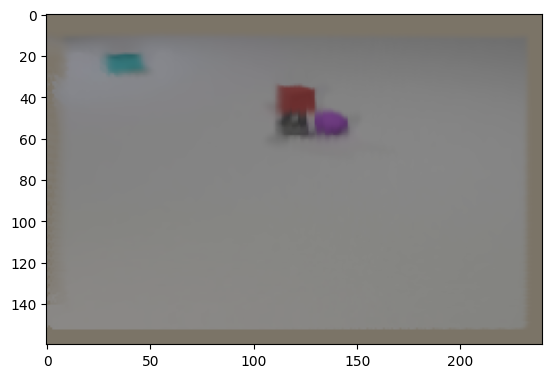

tensor(0.0192, device='cuda:0')
tensor(False, device='cuda:0')


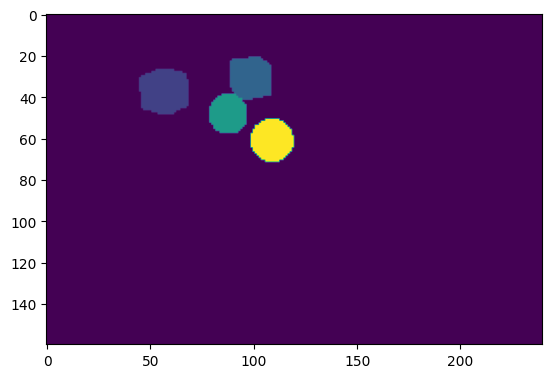

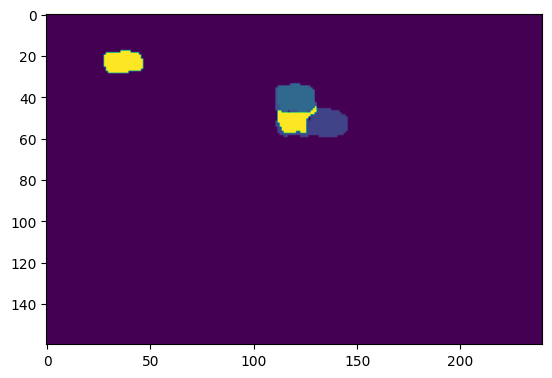

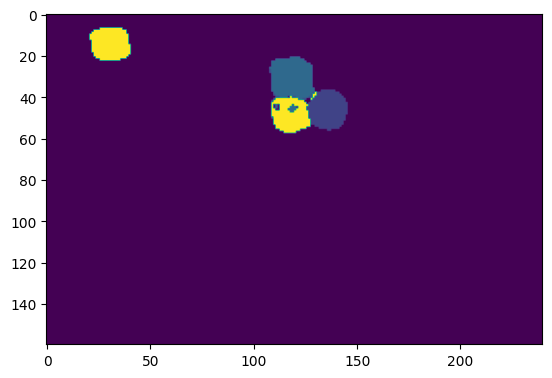

  2%|▎         | 25/1000 [00:33<21:19,  1.31s/it, Per frame Loss=0.874]

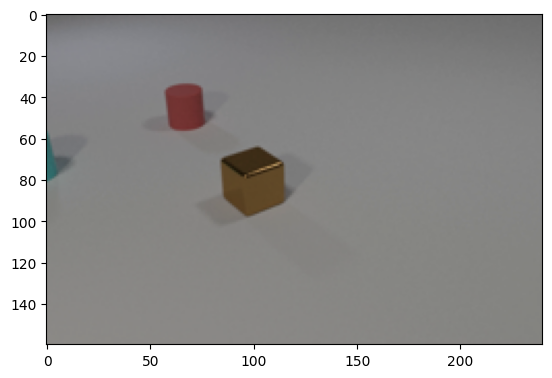

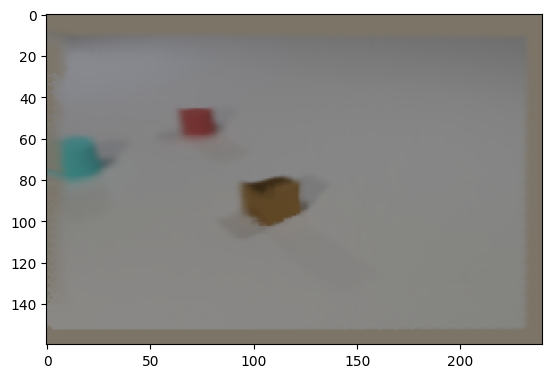

tensor(0.0187, device='cuda:0')
tensor(False, device='cuda:0')


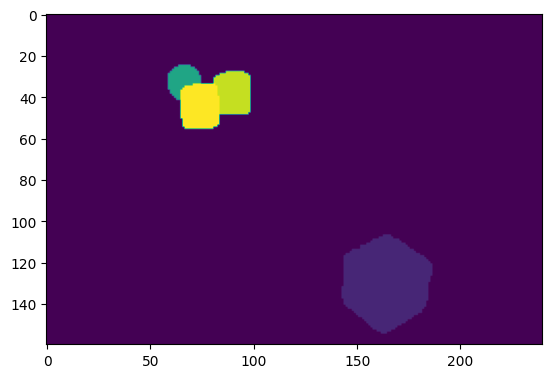

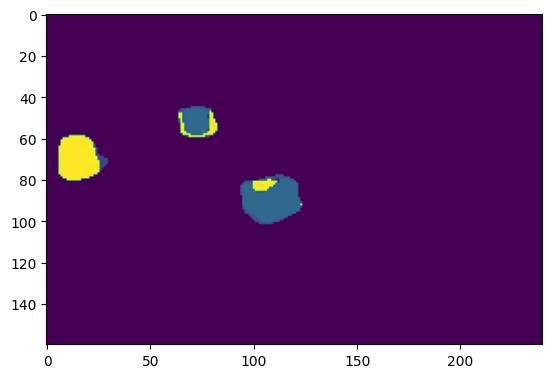

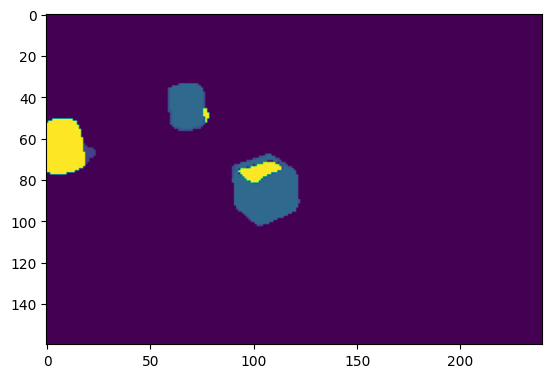

  3%|▎         | 26/1000 [00:34<21:09,  1.30s/it, Per frame Loss=0.55] 

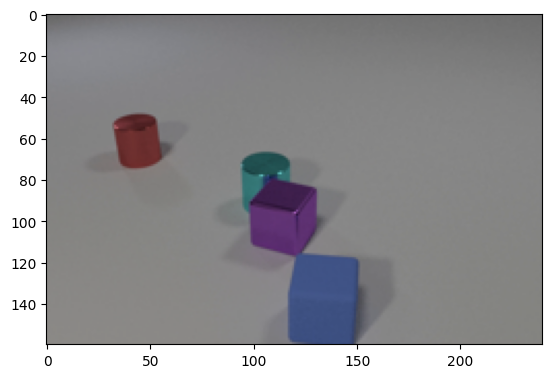

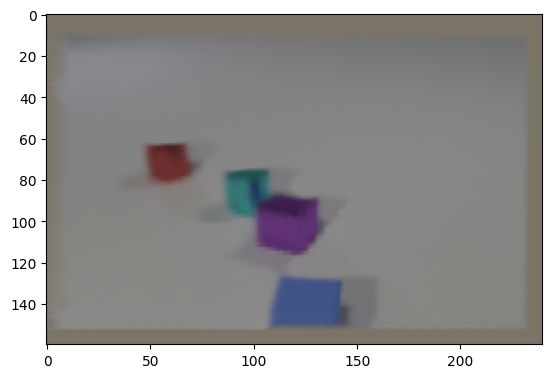

tensor(0.0255, device='cuda:0')
tensor(False, device='cuda:0')


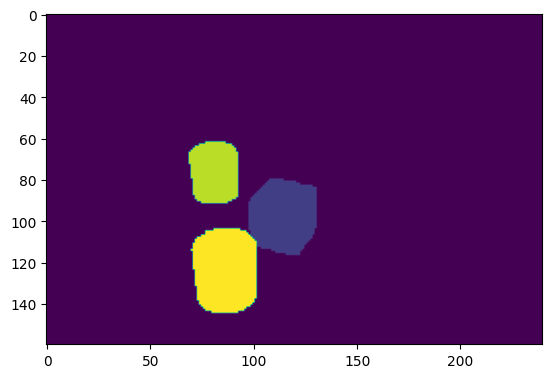

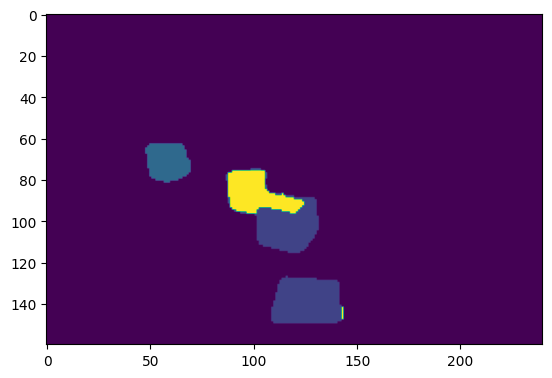

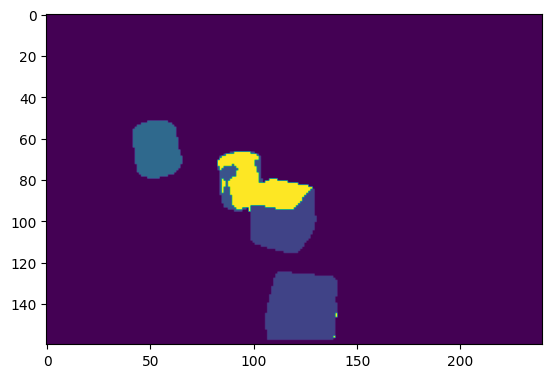

  3%|▎         | 27/1000 [00:36<21:04,  1.30s/it, Per frame Loss=0.496]

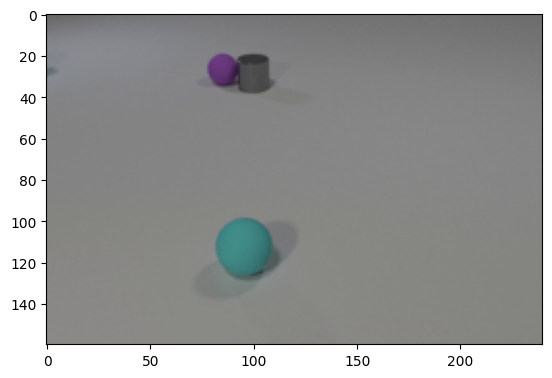

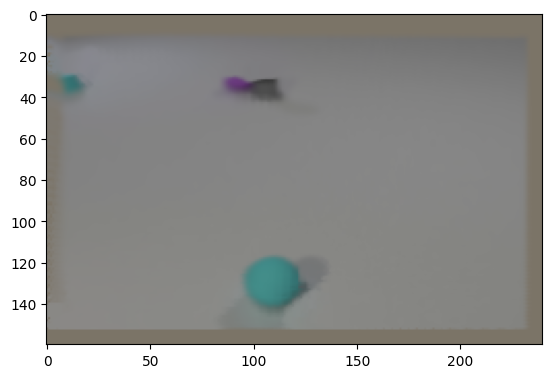

tensor(0.0196, device='cuda:0')
tensor(False, device='cuda:0')


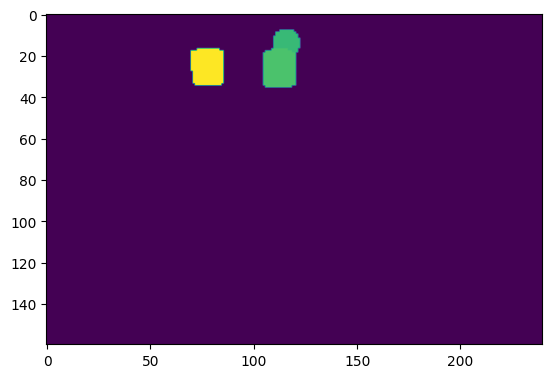

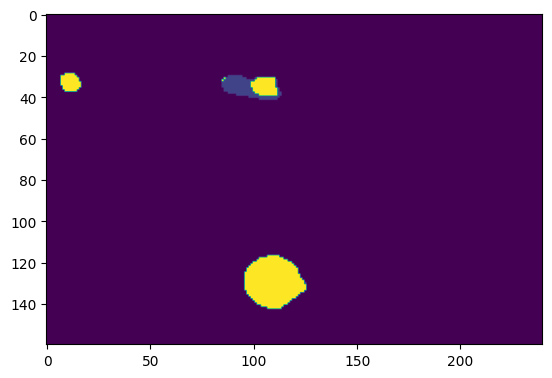

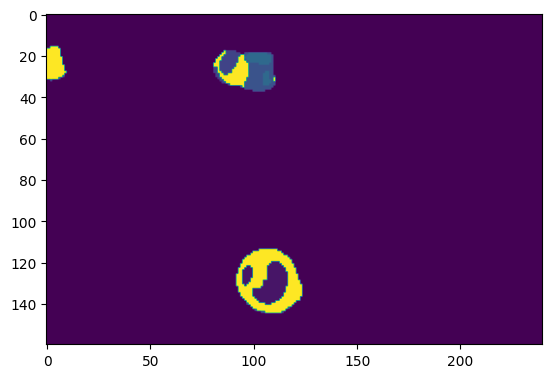

  3%|▎         | 28/1000 [00:37<21:02,  1.30s/it, Per frame Loss=0.239]

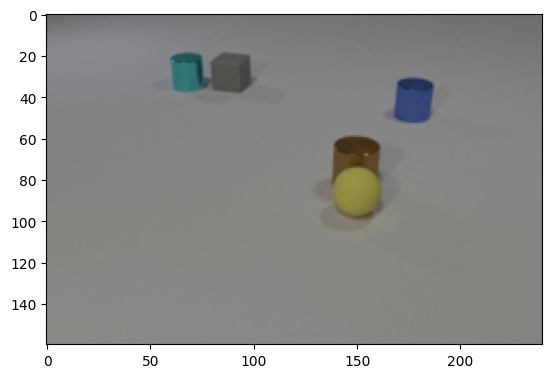

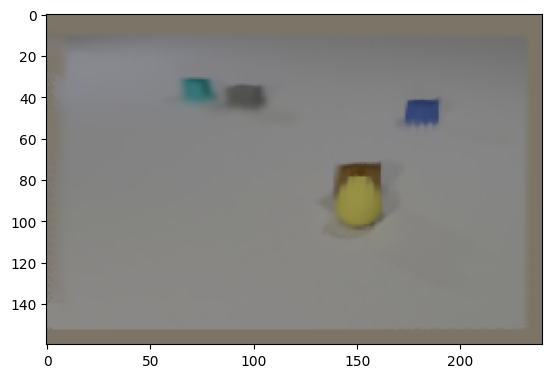

tensor(0.0191, device='cuda:0')
tensor(False, device='cuda:0')


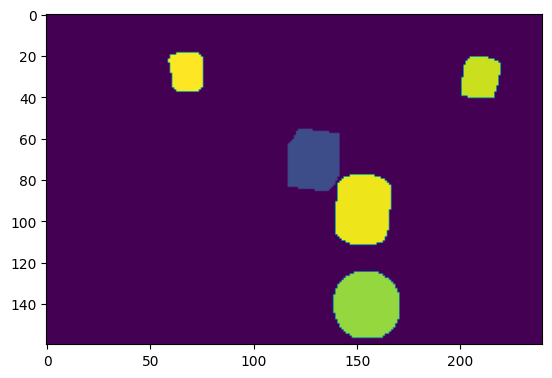

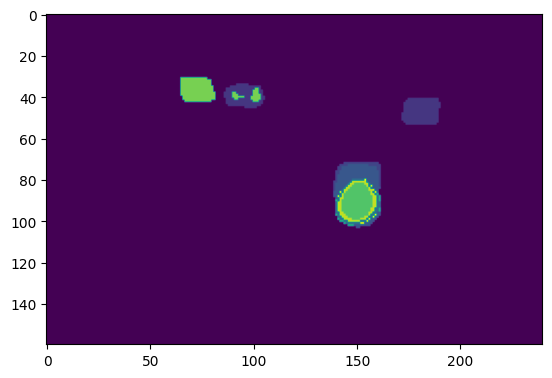

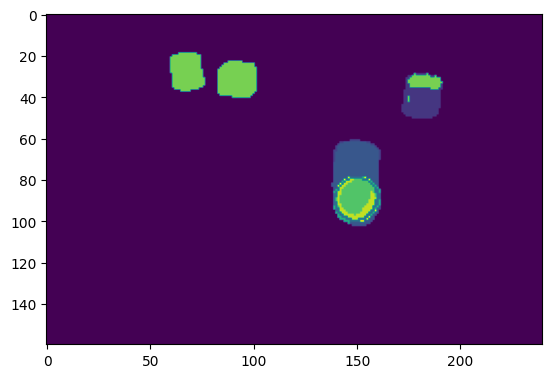

  3%|▎         | 29/1000 [00:38<21:02,  1.30s/it, Per frame Loss=0.509]

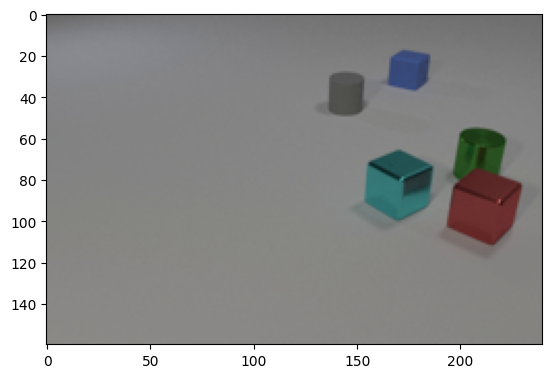

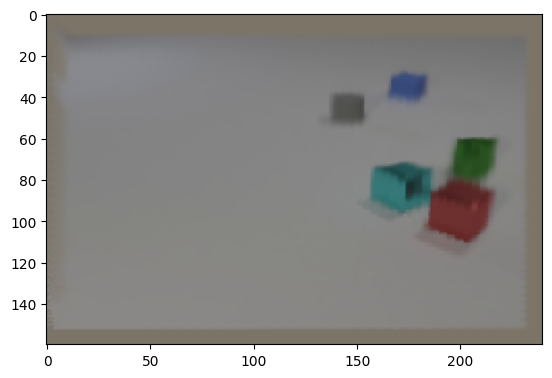

tensor(0.0179, device='cuda:0')
tensor(False, device='cuda:0')


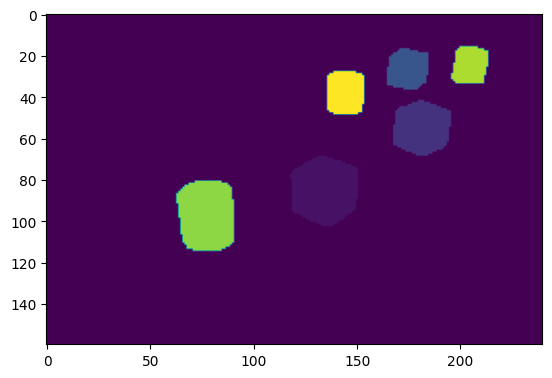

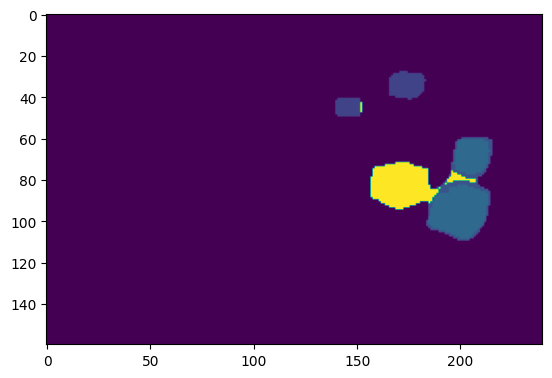

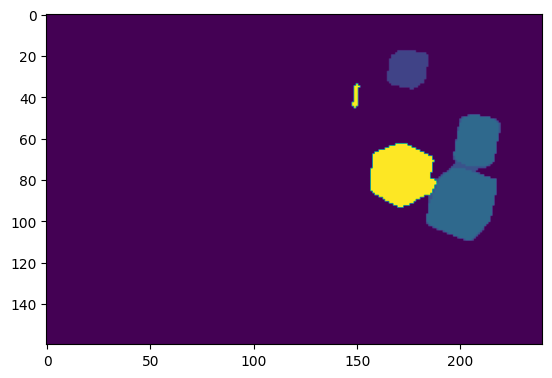

  3%|▎         | 30/1000 [00:40<22:25,  1.39s/it, Per frame Loss=0.878]

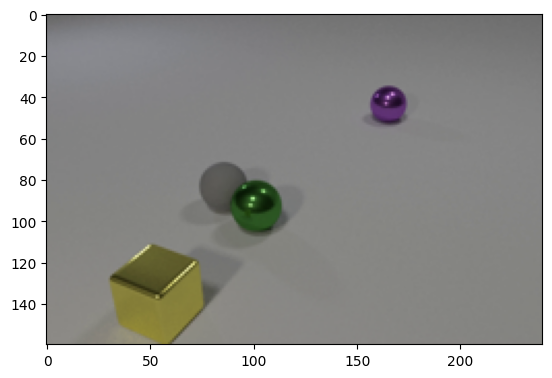

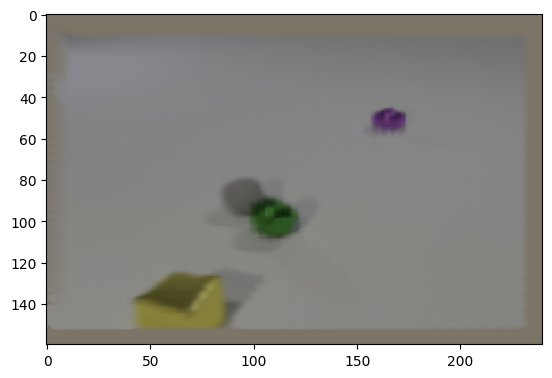

tensor(0.0188, device='cuda:0')
tensor(False, device='cuda:0')


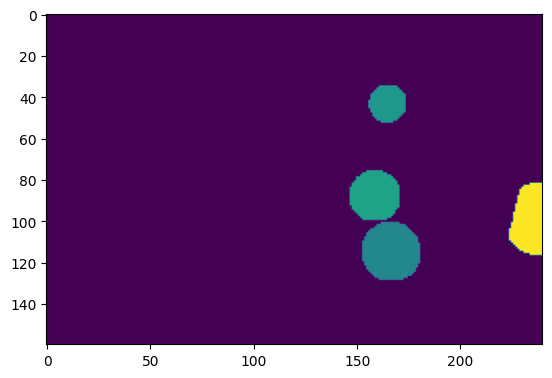

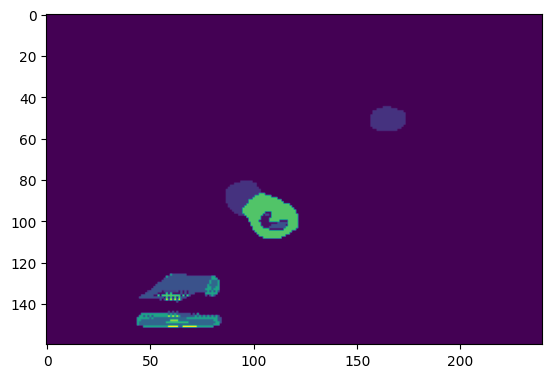

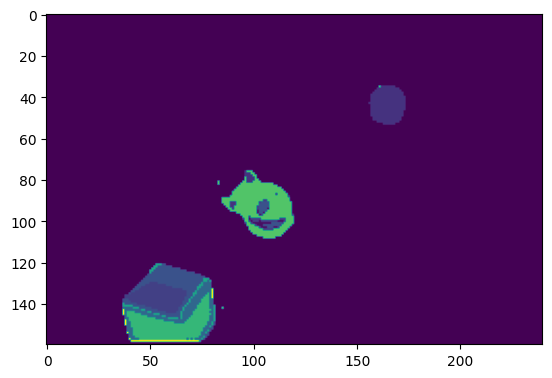

  3%|▎         | 31/1000 [00:41<22:05,  1.37s/it, Per frame Loss=0.353]

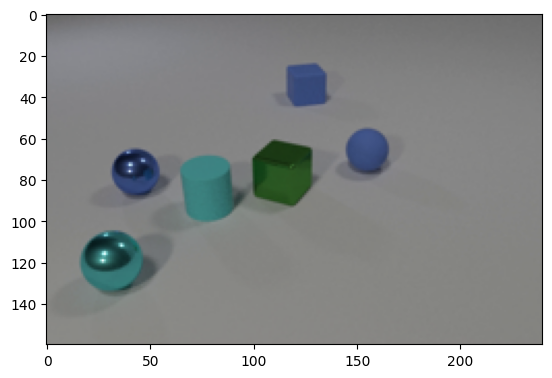

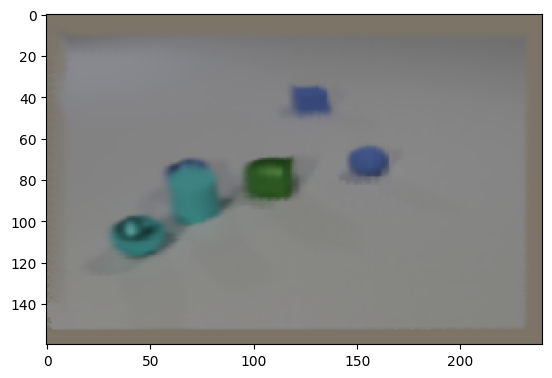

tensor(0.0186, device='cuda:0')
tensor(False, device='cuda:0')


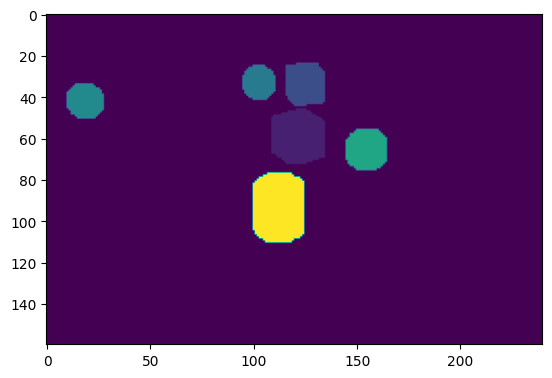

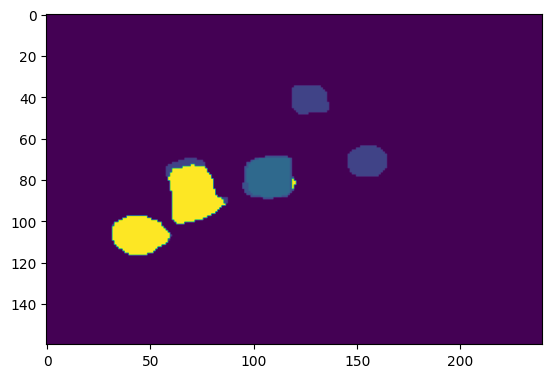

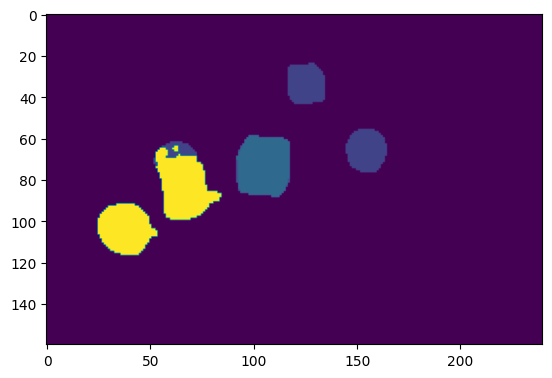

  3%|▎         | 32/1000 [00:42<21:40,  1.34s/it, Per frame Loss=0.551]

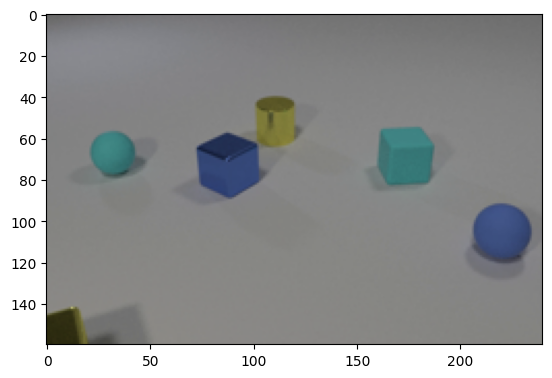

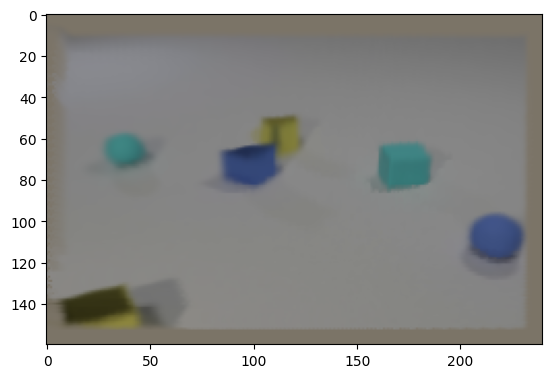

tensor(0.0191, device='cuda:0')
tensor(False, device='cuda:0')


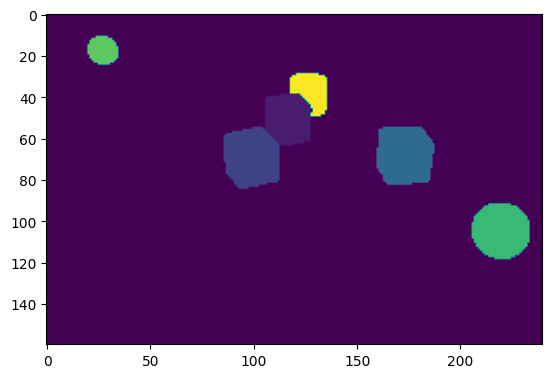

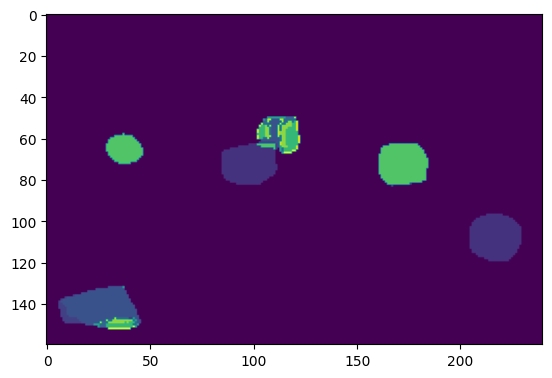

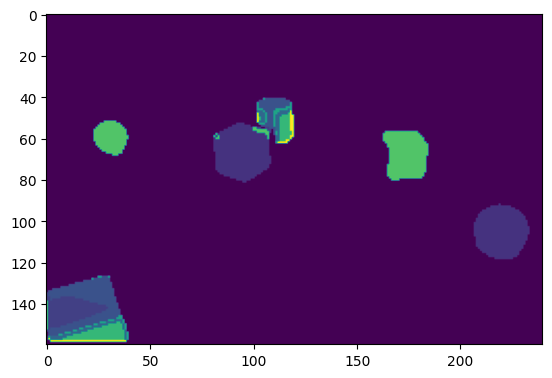

  3%|▎         | 33/1000 [00:44<21:53,  1.36s/it, Per frame Loss=0.336]

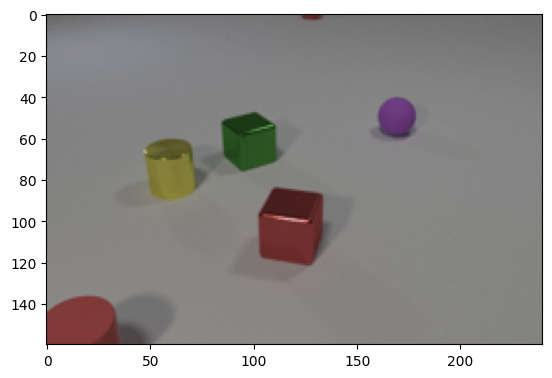

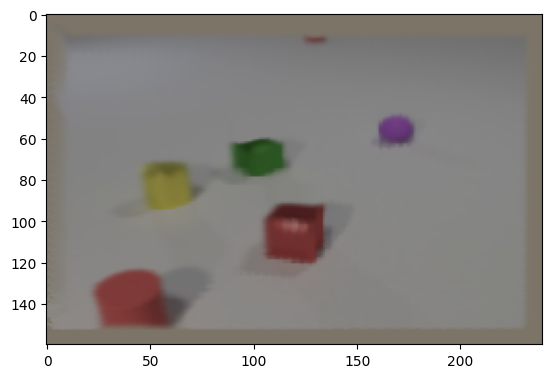

tensor(0.0187, device='cuda:0')
tensor(False, device='cuda:0')


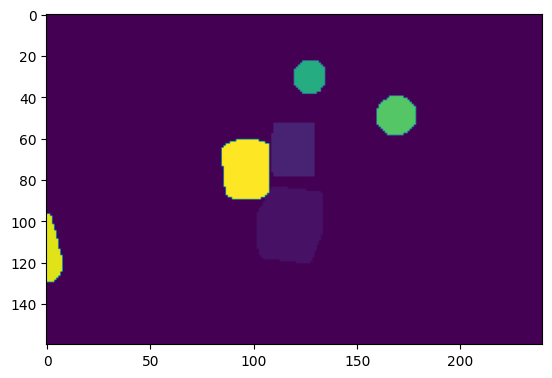

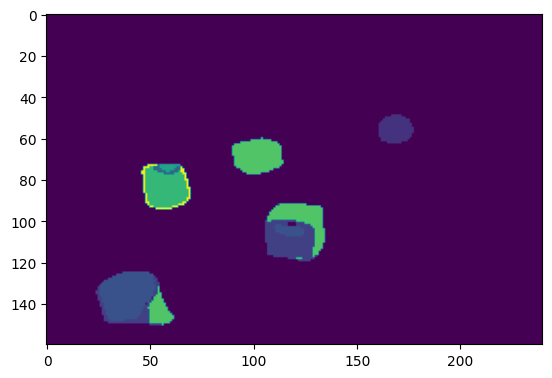

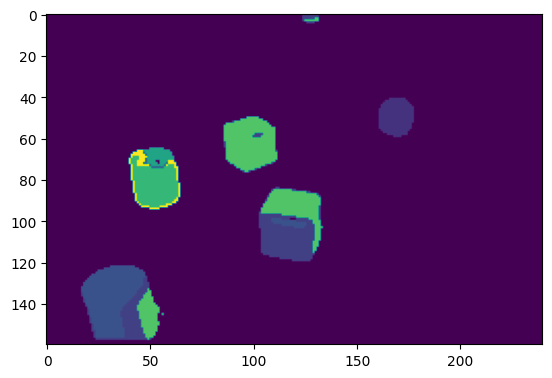

  3%|▎         | 34/1000 [00:45<21:45,  1.35s/it, Per frame Loss=0.391]

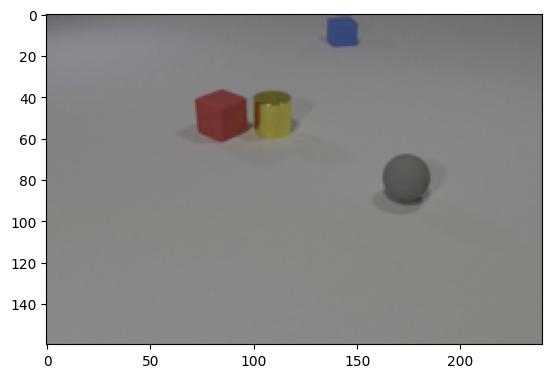

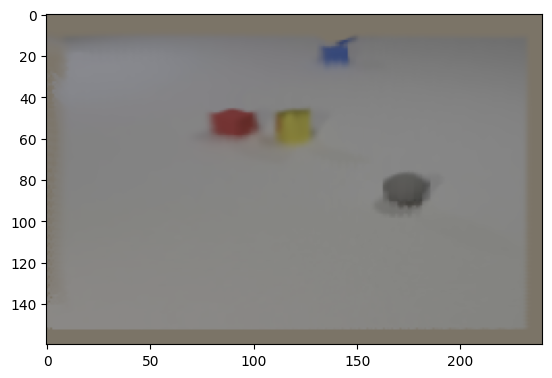

tensor(0.0193, device='cuda:0')
tensor(False, device='cuda:0')


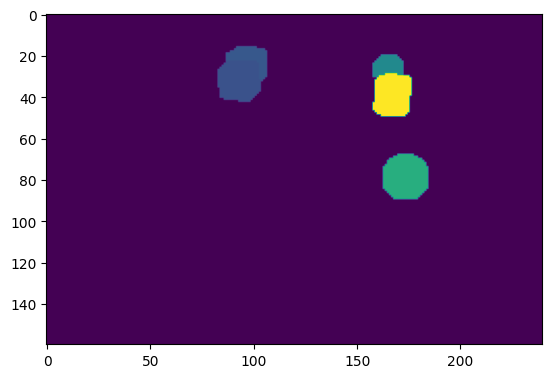

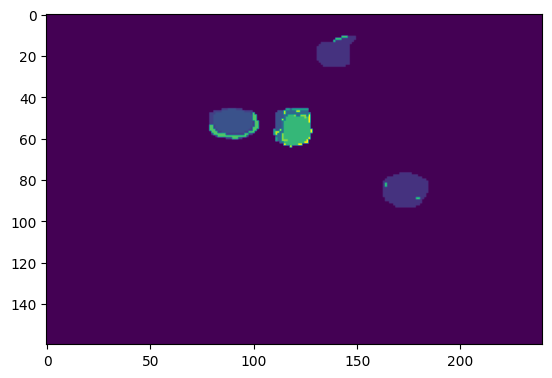

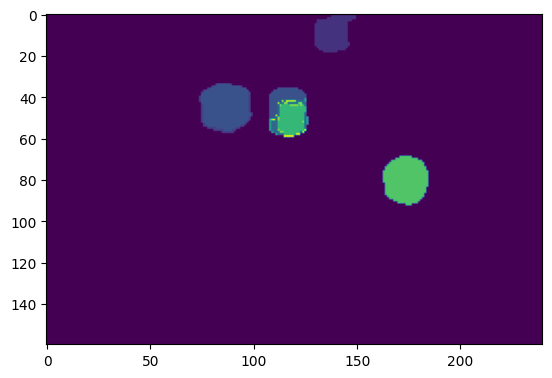

KeyboardInterrupt: 

In [41]:
real_test(downstream_model, MCJepa_model, 1, val_dataloader, criterion, downstream_optimizer)